<center><img src="https://www.pctleganes.org/images/asociados/uc3m.jpg" alt="UC3M Banner"/></center>

---
# PRÁCTICA 2: PREDICCIÓN DEL ABANDONO (BURNOUT) DE EMPLEADOS

**Realizado por:**
| GITHUB| NOMBRE |
| ------ | ------ |
| @DAlonso11 | Diego Alonso Herreruela | 
| @oteroantoniogom | Antonio Gómez Otero |
---

# PARTE 1: sin aplicar el filtrado

---
## Introducción

Al igual que en la práctica anterior, lo primero que haremos será importar las librerías necesarias para realizar la creación y evaluación de los modelos.

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import pickle

# Control de tiempos
# ==============================================================================
import time

# Gráficos 
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesado
# ==============================================================================
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
import missingno as msno
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
import multiprocessing

from scipy.stats import randint as sp_randint
from scipy.stats import uniform

# Logistic Regressor
# ==============================================================================
from sklearn.linear_model import LogisticRegression

# Gradient Boosting
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingClassifier

# XGBoost
# ==============================================================================
from xgboost import XGBClassifier

# Evaluacion
# ==============================================================================
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.inspection import permutation_importance

# Pipeline
# ==============================================================================
from sklearn.pipeline import Pipeline

---
## Conjunto de datos

Este apartado está dedicado a leer los **datos proporcionados**. Al igual que hicimos en la Práctica 1, como nuestro grupo es el 22 debemos tratar  el desgaste de los empleados en los datos correspondientes al nº22.

In [2]:
with open("attrition_available_22.pkl", 'rb') as file:
    disp_df = pickle.load(file)
disp_df.nunique()

hrs                        4406
absences                     24
JobInvolvement                4
PerformanceRating             2
EnvironmentSatisfaction       4
JobSatisfaction               4
WorkLifeBalance               4
Age                          43
Attrition                     2
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeID                 3644
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1341
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
dtype: i

---
## Análisis exploratorio

### EDA

In [3]:
print('La forma de la tabla es de:')
print('===============================')
print(str(len(disp_df.index)) + ' filas y ' + str(len(disp_df.columns)) + ' columnas')
print()

print('Los atributos son de tipo:')
print('================================')
print(disp_df.dtypes)

print()

print('Los valores que faltan suman un total de:')
print('======================================')
print(disp_df.isnull().sum())

print()

print('La fraccion de valores que faltan por cada atributo es:')
print('======================================')
print(disp_df.isnull().mean())

print()

print('Cantidad de filas duplicadas:')
print('===============================')
print(disp_df.duplicated().sum())
print()

print()

print('Cantidad de valores únicos:')
print('================================')
print(disp_df.nunique())


La forma de la tabla es de:
4410 filas y 31 columnas

Los atributos son de tipo:
hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome           float64
Education                    int64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours              float64
StockOptionLevel           float64
TotalWork

Para determinar si nos encontramos antes un problema de clasificación o de regresión, debemos prestar atención a la variable objetivo, **Attrition**. 
Para ello, veremos el tipo de la variable Attrition. Si es **object**, será clasificación.

In [84]:
print('Como el tipo de la variable de salida (Attrition) es ' + str(disp_df.loc[:,'Attrition'].dtype) + ', estamos ante un problema de' + (' clasificación.' if str(disp_df.loc[:,'Attrition'].dtype) == 'object' else ' regresión.' ))

Como el tipo de la variable de salida (Attrition) es object, estamos ante un problema de clasificación.


Además, para confirmar nuestra hipótesis, también veremos las diferentes instancias.
En el contexto de evalurar predicción del abandono de empleados...
- si es un problema de clasificación:
    *la variable objetivo tomará valores categóricos, como **Yes**|**No** o **1**|**0***.
- si es un problema de regresión:
    *la variable objetivo tomará valores que representen una **cantidad continua***.

In [85]:
X_df = disp_df.drop('Attrition', axis=1)
attri_count = disp_df['Attrition'].value_counts()
y_df = disp_df.Attrition
y_df.value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

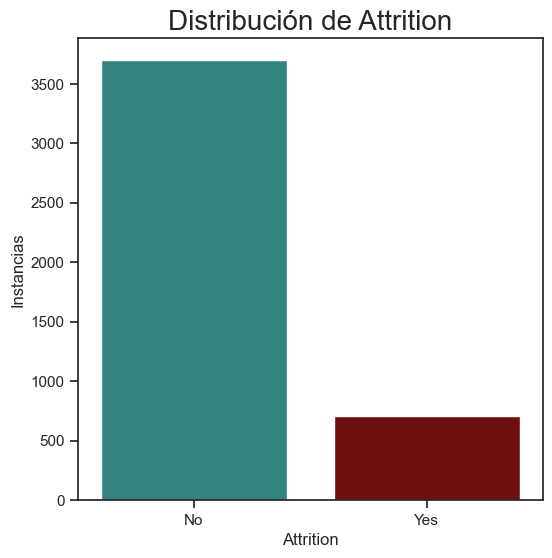

In [86]:
fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(x=attri_count.index, y=attri_count.values, palette=['#25918a', '#7e0100'])
plt.title("Distribución de Attrition",fontsize = 20)
plt.ylabel('Instancias', fontsize = 12)
plt.xlabel('Attrition', fontsize = 12);

Como se puede observar este dataset corresponde a un problema de **clasificación**.

Por otro lado, como la cantidad de instancias de la clase *No* es mucho mayor que las instancias de la clase *Yes*, podemos concluir que está **altamente desbalanceado**. Por ello hay que ser especialemente cauteloso a la hora de trabajar con el mismo.

### Visualización de los datos

array([[<Axes: title={'center': 'hrs'}>,
        <Axes: title={'center': 'absences'}>,
        <Axes: title={'center': 'JobInvolvement'}>,
        <Axes: title={'center': 'PerformanceRating'}>,
        <Axes: title={'center': 'EnvironmentSatisfaction'}>],
       [<Axes: title={'center': 'JobSatisfaction'}>,
        <Axes: title={'center': 'WorkLifeBalance'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'Education'}>],
       [<Axes: title={'center': 'EmployeeCount'}>,
        <Axes: title={'center': 'EmployeeID'}>,
        <Axes: title={'center': 'JobLevel'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>],
       [<Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'StandardHours'}>,
        <Axes: title={'center': 'StockOptionLevel'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'cent

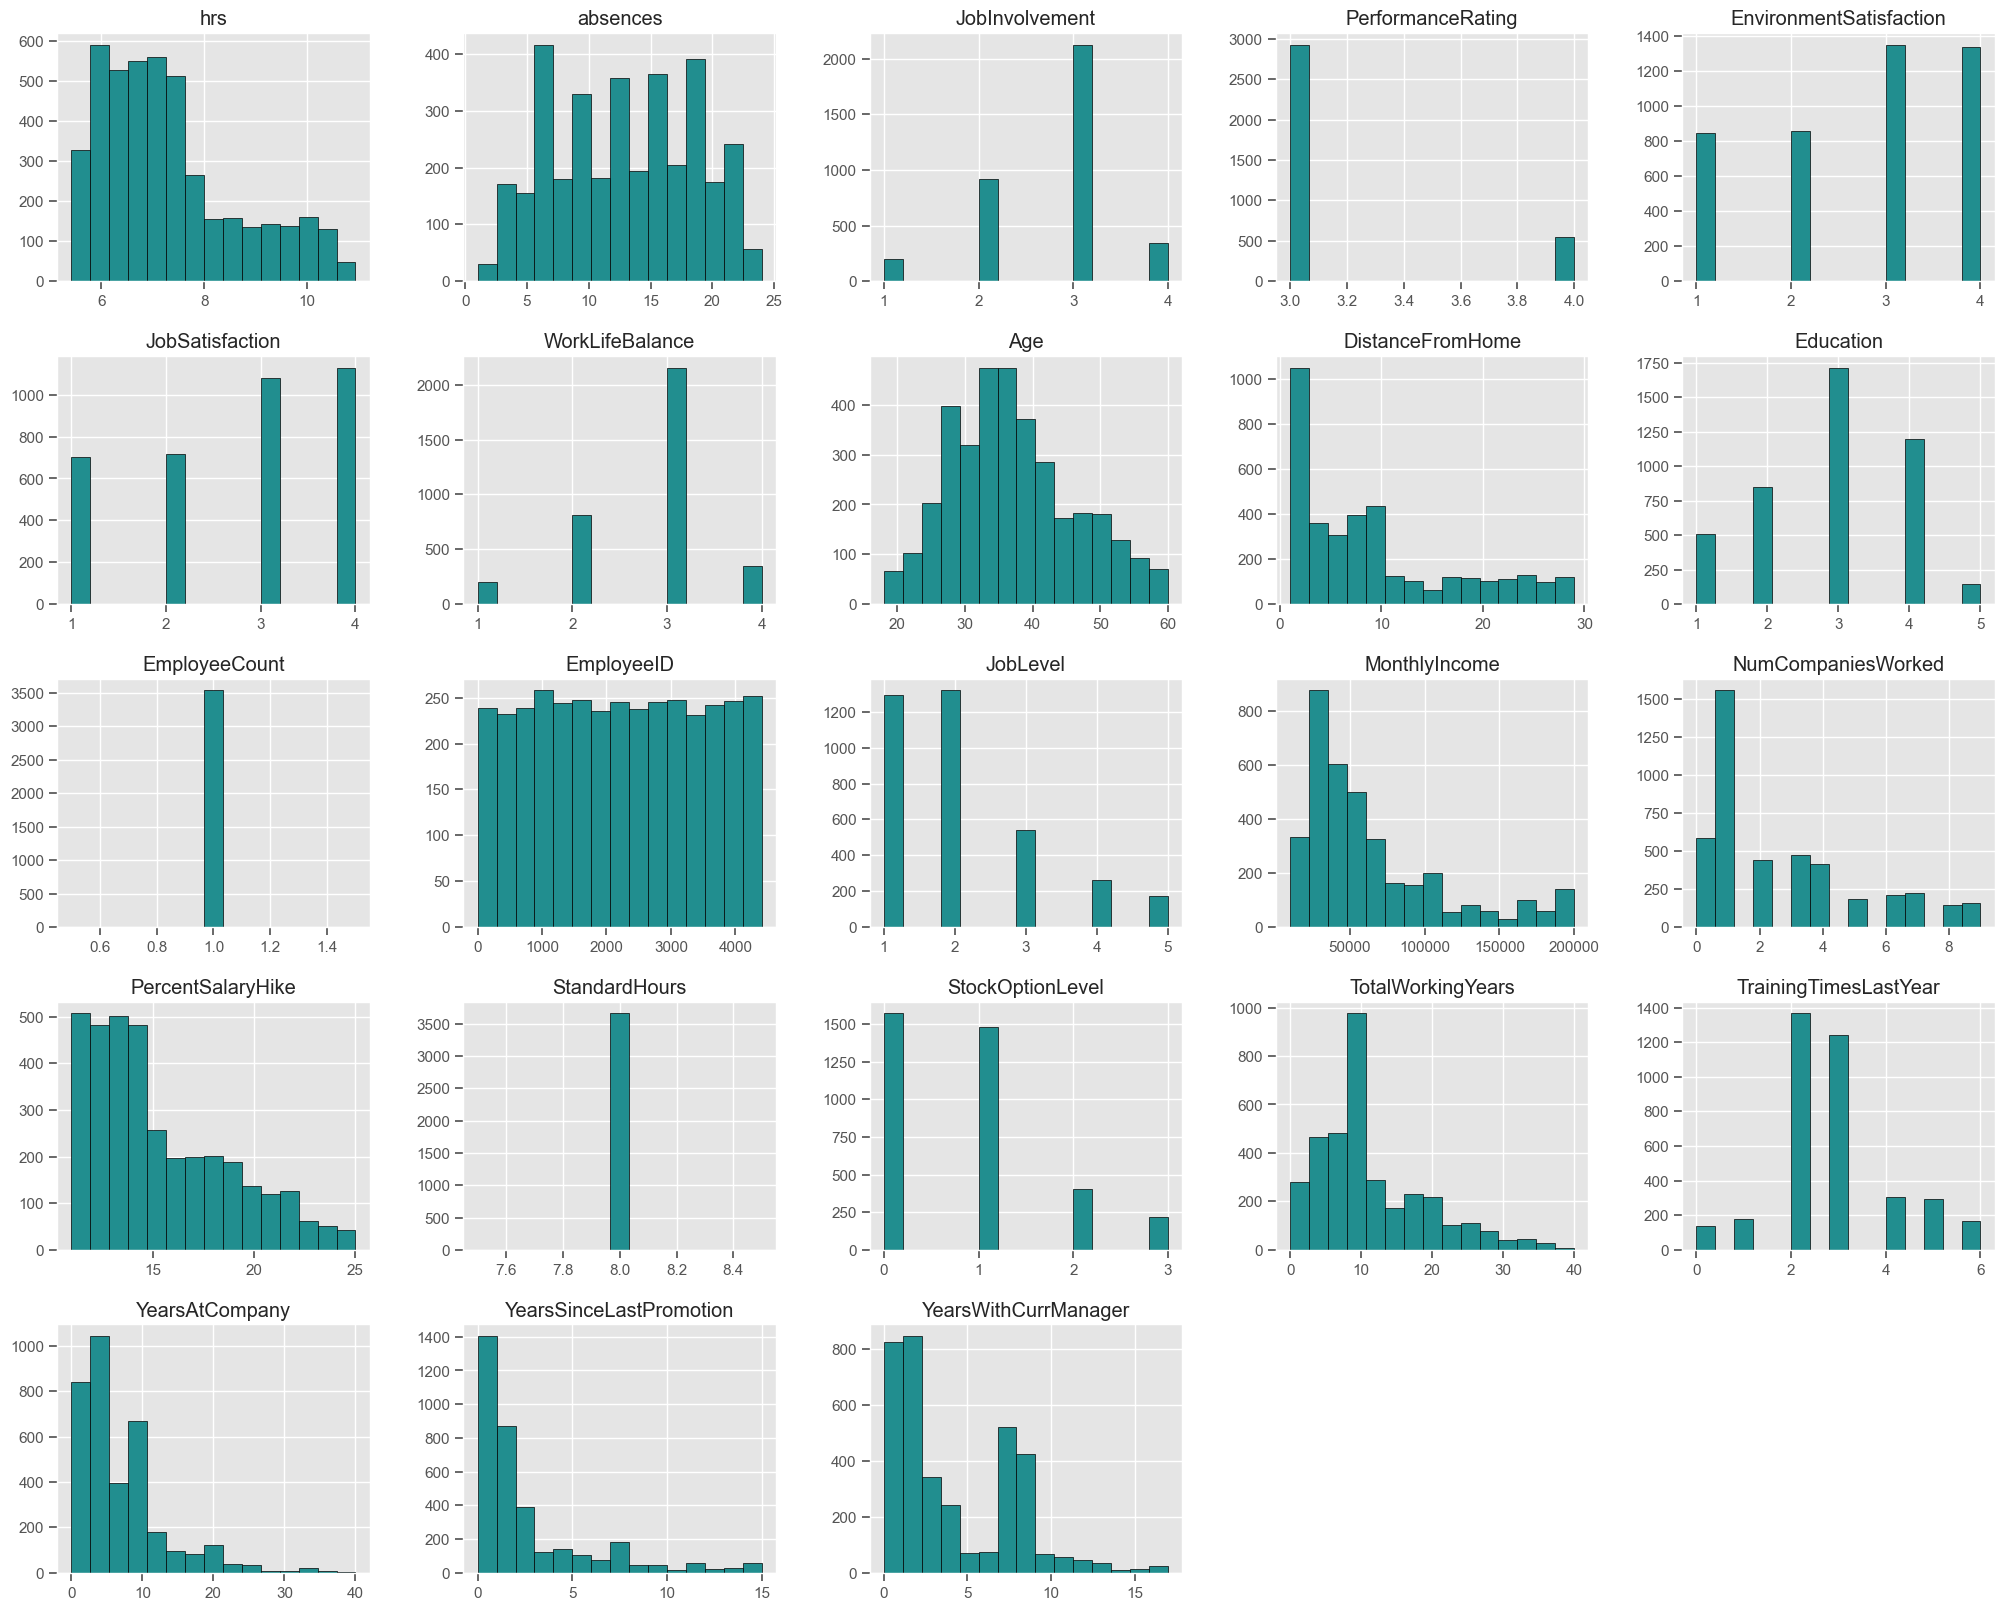

In [87]:
plt.style.use("ggplot")
disp_df.hist(figsize=(25, 20), bins=15, edgecolor='black', color='#218e8f')


C:\Users\otero\AppData\Local\Temp\ipykernel_14640\2882821518.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = disp_df.corr()
C:\Users\otero\AppData\Local\Temp\ipykernel_14640\2882821518.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(disp_df.corr(), dtype=bool))


Text(0.5, 1.0, 'Correlation Heatmap')

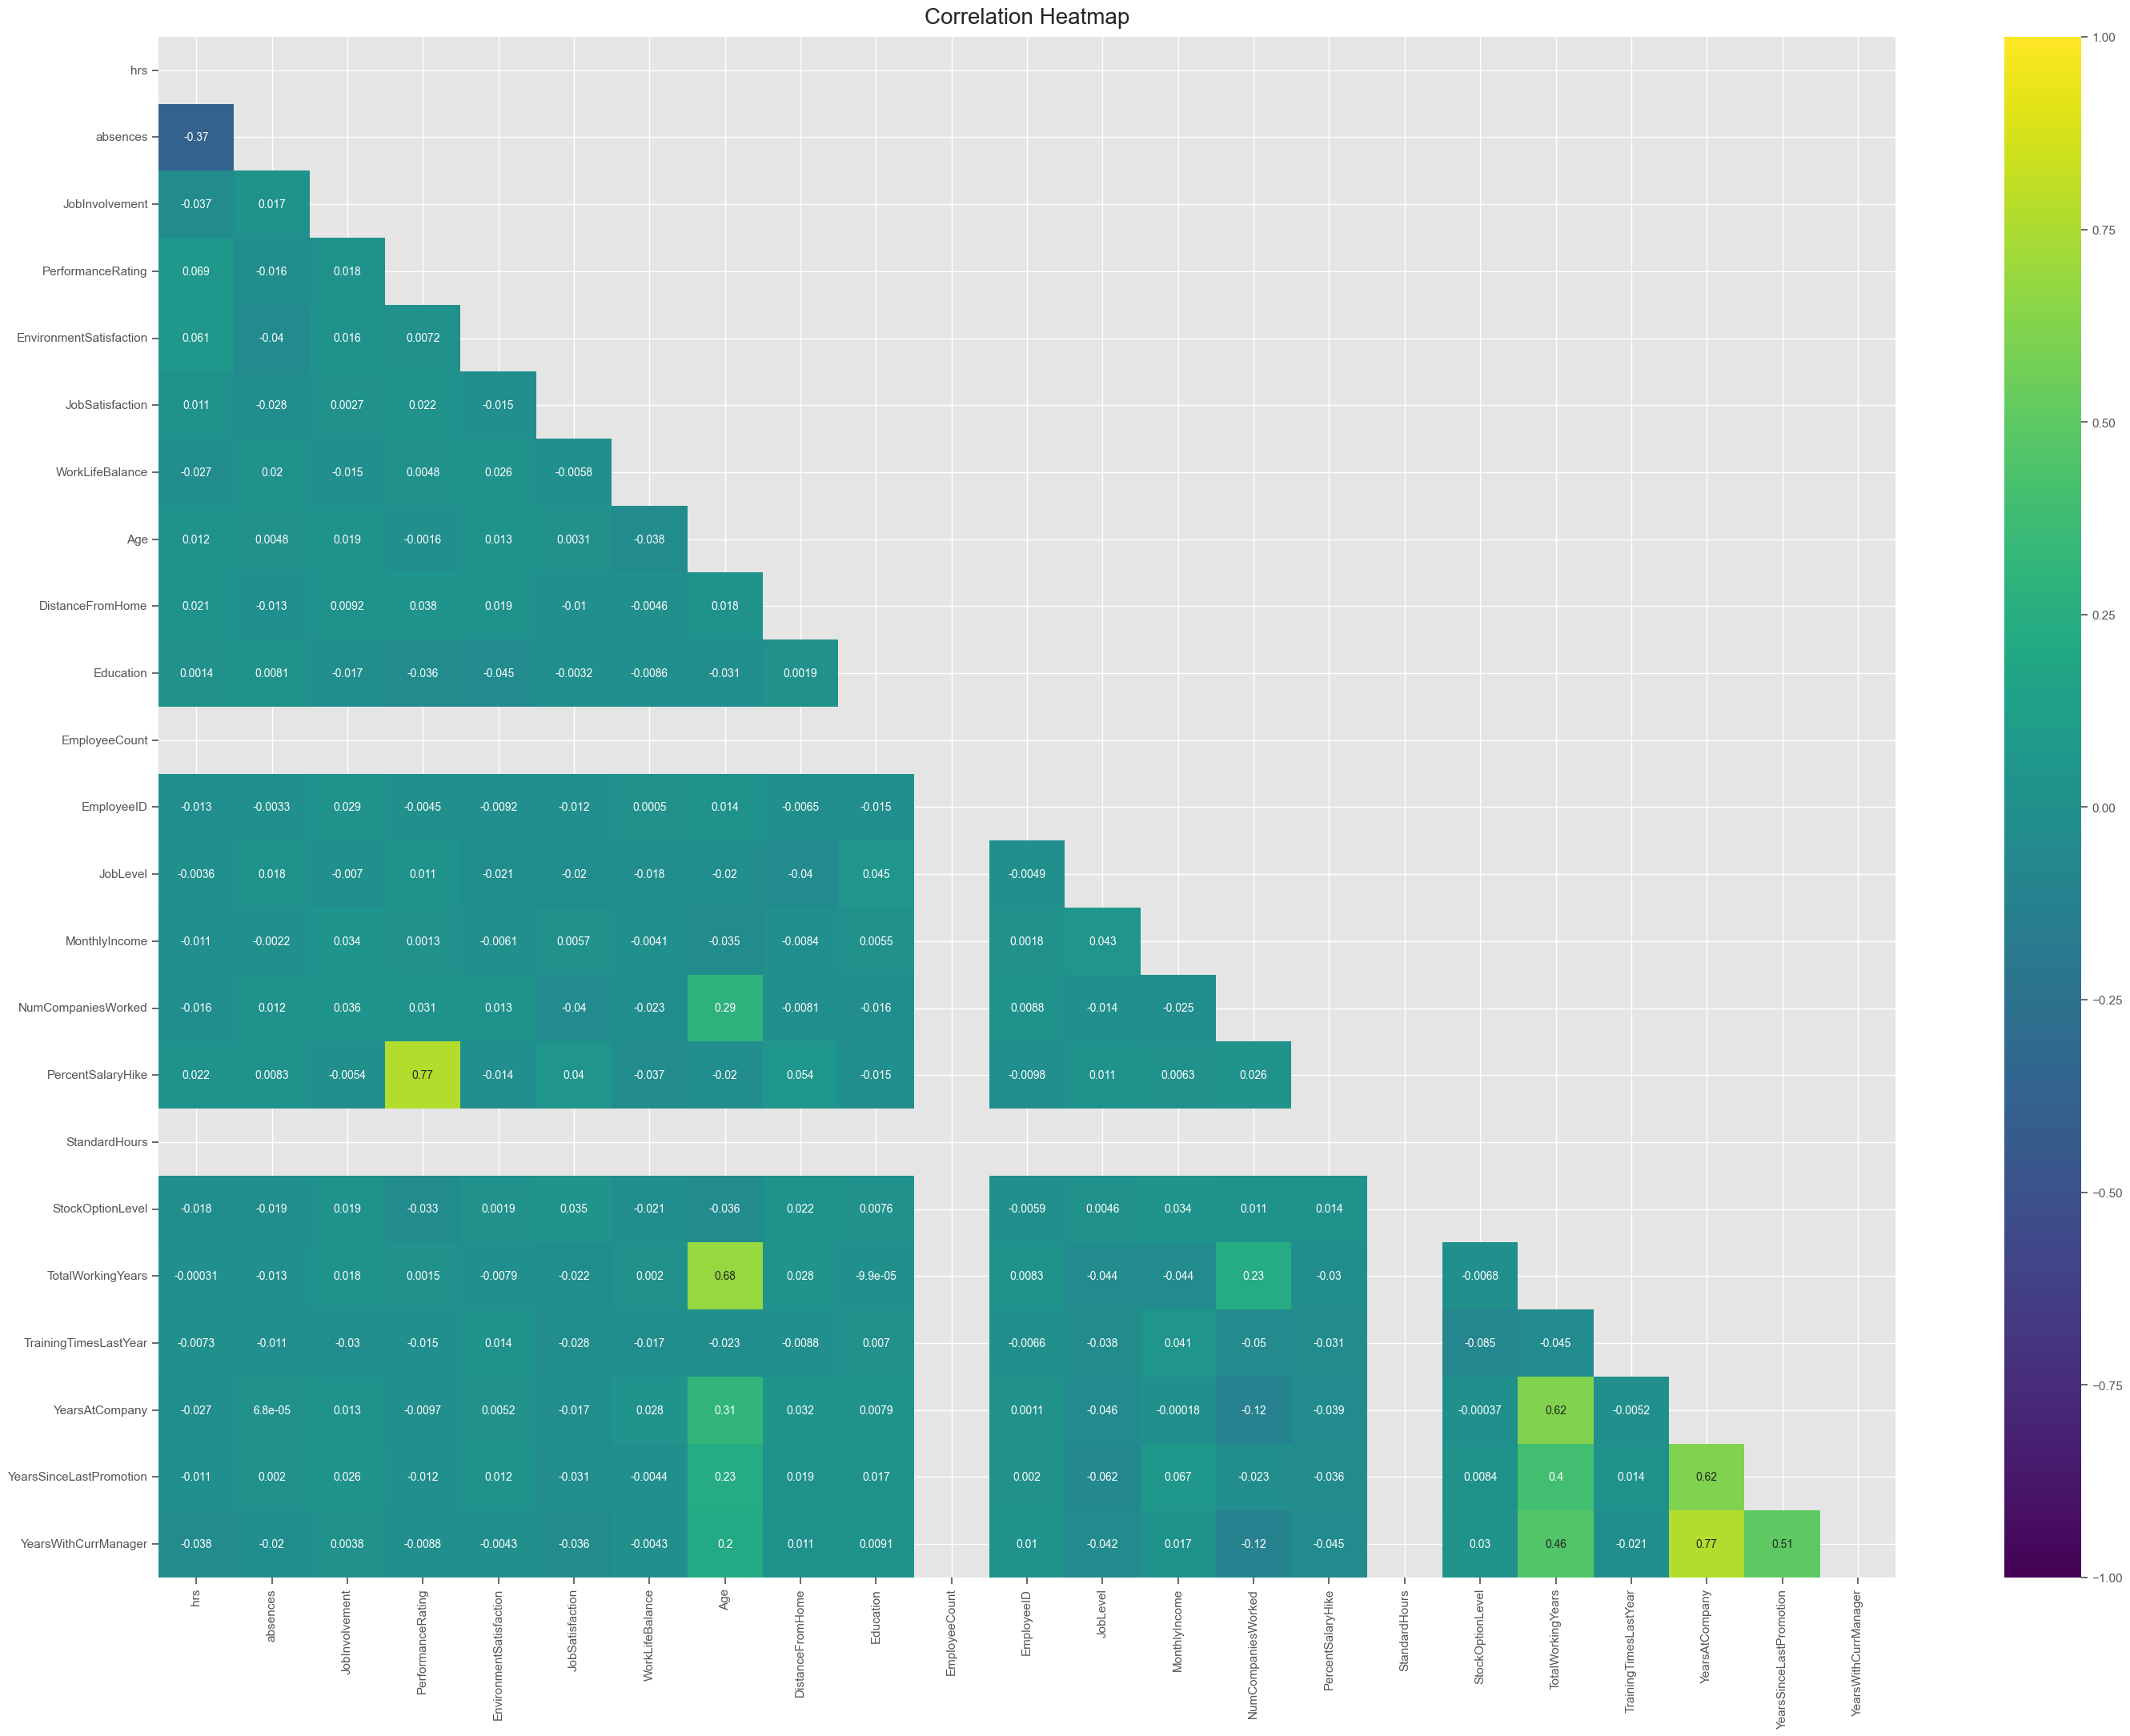

In [88]:
plt.figure(figsize=(35,25))
corr = disp_df.corr()
mask = np.triu(np.ones_like(disp_df.corr(), dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='viridis')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)


Viendo tanto el mapa de calor de correlación como los siguientes prints con los valores de *StandardHours* y *EmployeeCount*, podemos afirmar que estas variables no nos van a ser nada útiles. 

In [89]:
disp_df['EmployeeCount'].unique()

array([ 1., nan])

In [90]:
disp_df['StandardHours'].unique()

array([nan,  8.])

Así mismo, usando la lógica, al ver las diferentes variables con las que trabajamos es preciso caer en la cuenta de que *Over18* debe ser siempre Yes, ya que si no se estaría cometiendo una ilegalidad. En efecto, al ver los diferentes resultados, vemos que siempre es Yes.

In [91]:
disp_df['Over18'].unique()

array(['Y', nan], dtype=object)

### Tratamiento de columnas no relevantes
Como sabemos, es común que al trabajar con conjuntos de datos no todas las variables sean relevantes para el análisis que se pretende llevar a cabo. Por ello, hemos decidido examinar aquellas variables que podrían ntener poco impacto en el resultado final.

 En este caso, como nuestro dataset tiene como objetivo **predecir el abandono de empleados en una empresa**, creemos haber identificado algunas variables que no son relevantes para el análisis y que se han eliminado para simplificar el modelo. 
 
 Esto lo hacemos siempre con el objetivo de eliminar variables innecesarias puede mejorar la precisión del modelo y reducir la complejidad del análisis.


Si una variable tiene el mismo valor para todos los ejemplos en el conjunto de datos, entonces esa variable no proporciona ninguna información útil para el modelo. Por lo tanto, es seguro eliminarla sin preocuparse de que se pierda información importante. Además, mantener variables que siempre tienen el mismo valor puede aumentar el costo computacional y ralentizar el proceso de entrenamiento del modelo sin ofrecer ningún beneficio.

#### Variables a eliminar

La variable **EmployeeCount** contiene siempre el valor 1 para todas las instancias, por lo que no aporta información útil para el análisis y puede ser eliminada.

La variable **StandardHours** contiene siempre el valor 8 para todas las instancias, por lo que no aporta información útil para el análisis y puede ser eliminada.

La variable **EmployeeID** es simplemente un identificador único para cada empleado en la empresa, y no tiene relación con la variable objetivo Attrition (se puede observar con nunique()) Por lo tanto, esta variable tampoco es relevante para el análisis.

La variable **Gender** puede parecer relevante, ya que la discriminación de género podría ser una causa de abandono de la empresa. Sin embargo, en este caso no se tienen datos de salarios, ascensos u otras variables que pudieran estar relacionadas con la discriminación de género, por lo que no se justifica incluirla en el análisis. Además, creemos que no debería ser relevante el género de la persona.

Finalmente, la variable **Over18** contiene siempre el valor "Y" para todas las instancias, por lo que tampoco aporta información útil y puede ser eliminada. 

En conclusión, estas variables no son relevantes para el análisis de Attrition y pueden ser eliminadas para simplificar el modelo.

In [92]:
# Borrado de las variables que no interesan
X_df.drop(['EmployeeCount', 'EmployeeID', 'Gender', 'StandardHours', 'Over18'], axis=1, inplace=True)
print('La forma de la tabla original, disp_df, es de:')
print('===============================')
print(str(len(disp_df.index)) + ' filas y ' + str(len(disp_df.columns)) + ' columnas')
print()
print('La forma de la tabla modificada, X_df (también sin Attrition), es de:')
print('===============================')
print(str(len(X_df.index)) + ' filas y ' + str(len(X_df.columns)) + ' columnas')
print()

La forma de la tabla original, disp_df, es de:
4410 filas y 31 columnas

La forma de la tabla modificada, X_df (también sin Attrition), es de:
4410 filas y 25 columnas



<Axes: >

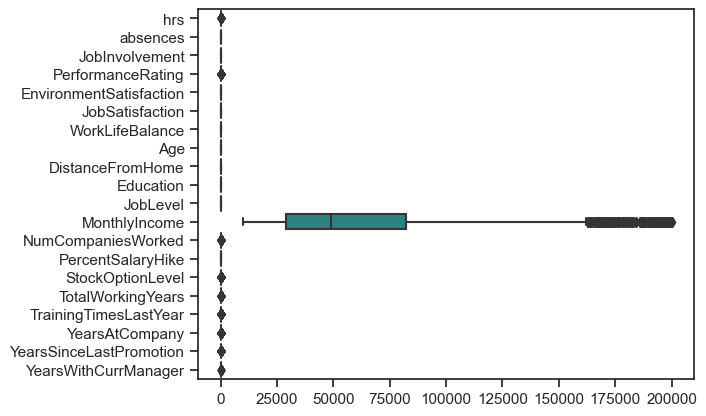

In [93]:
# Dibujar el boxplot de todas las variables
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=X_df, orient="h", color='#218e8f')

Como se puede ver, el rango de valores de las diferentes variables hace que sea imposible sacar conclusiones. Por ello, normalizamos los datos y volvemos a mostrar por pantalla.

C:\Users\otero\AppData\Local\Temp\ipykernel_14640\2209118998.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_data = (X_df - X_df.mean()) / X_df.std()
C:\Users\otero\AppData\Local\Temp\ipykernel_14640\2209118998.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_data = (X_df - X_df.mean()) / X_df.std()


<Axes: >

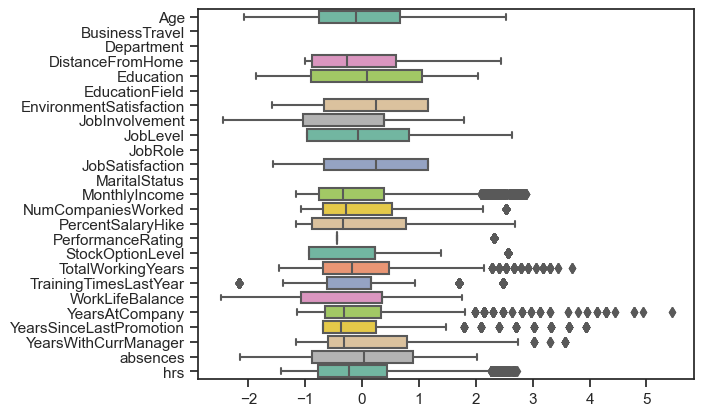

In [94]:
normalized_data = (X_df - X_df.mean()) / X_df.std()
# Dibujar el boxplot de todas las variables
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=normalized_data, orient="h", palette="Set2")

Después de observar las estadísticas presentadas y analizar el boxplot, se puede concluir que no hay ninguna variable que deba ser eliminada. No hay ninguna variable que presente continuamente el mismo valor.

Por lo tanto, en base a estos resultados, podemos decir que ya no es necesario eliminar ninguna variable del conjunto de datos.

### Tratamiento de variables con valores nulos


Es bien sabido que los valores nulos afectan a la calidad de los datos; ergo, afectan a la calidad del modelo. Por ello, antes de seguir con el modelo tenemos que seguir refinándolo y preparándolo para su posterior análisis.

Esta es la representación de los valores nulos:


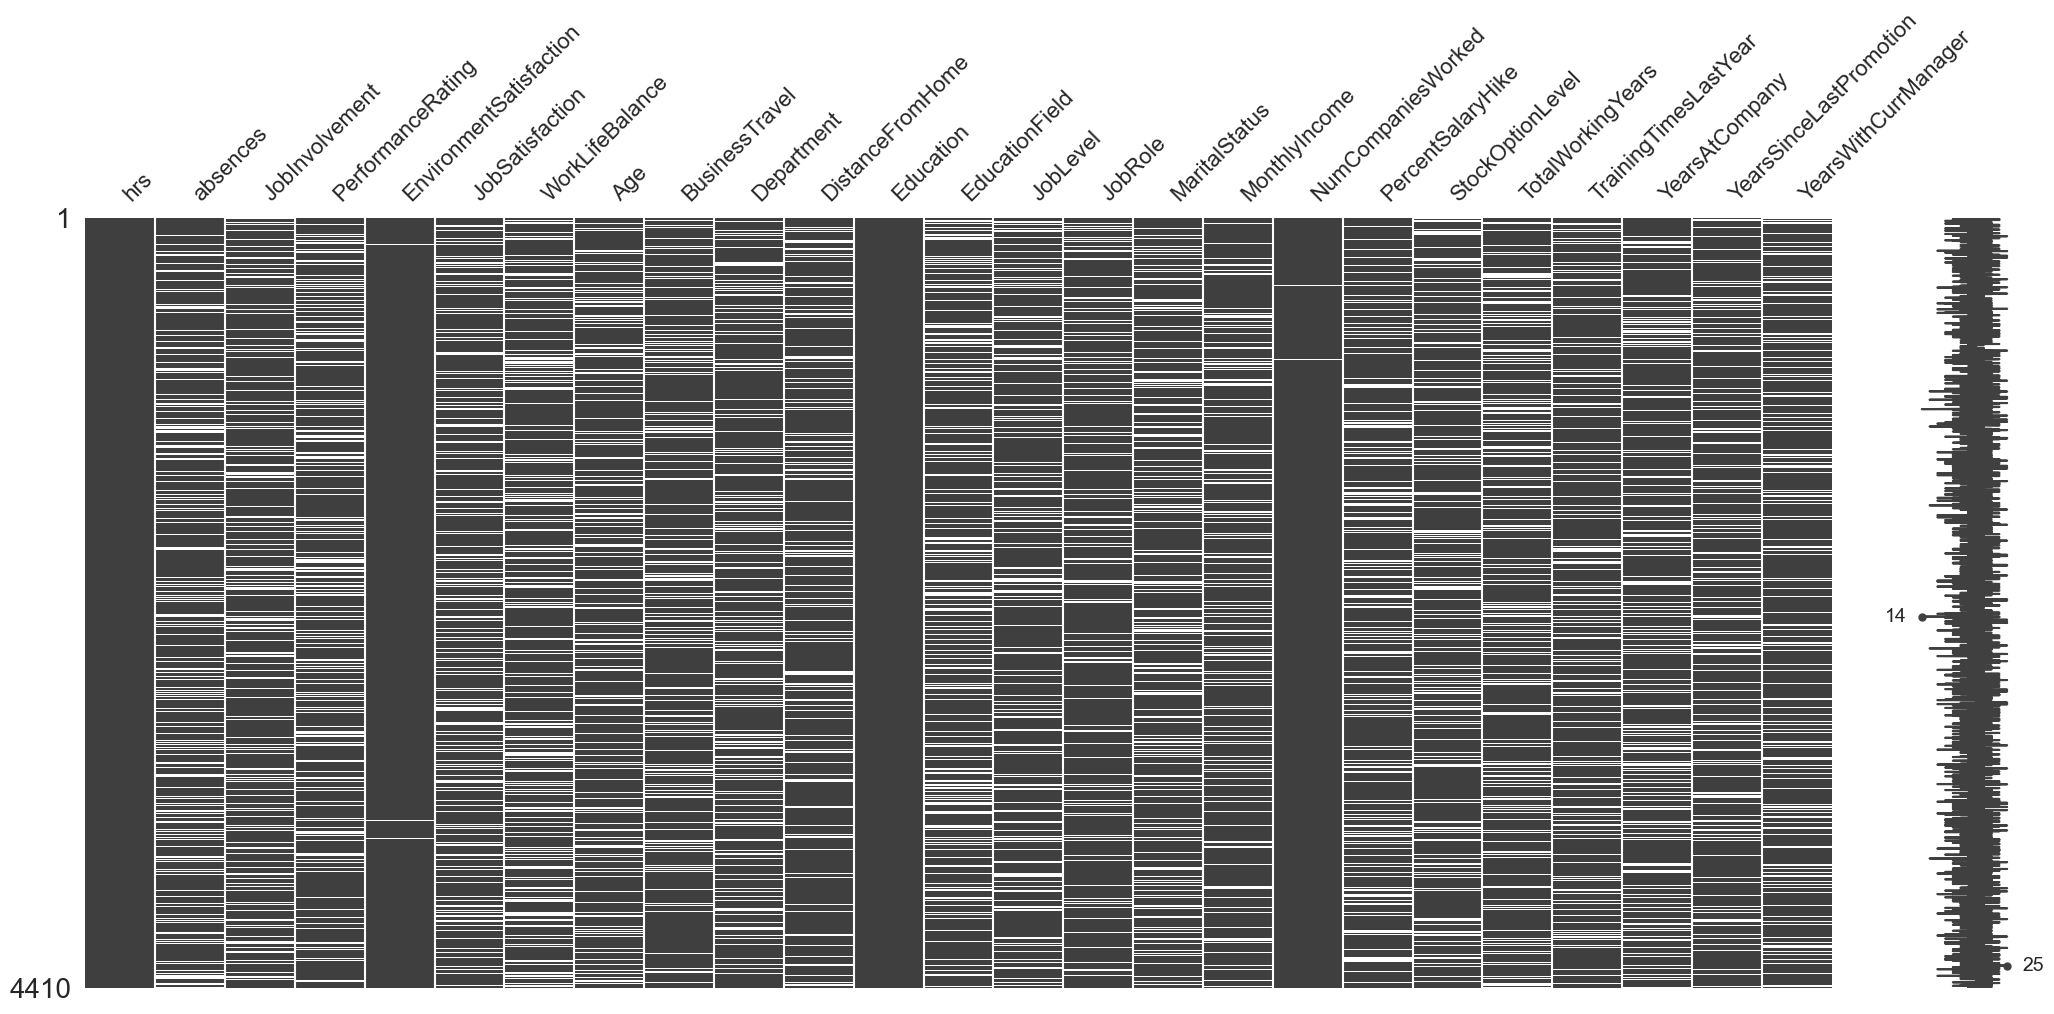

In [95]:
print('Esta es la representación de los valores nulos:')
print('======================================')
%matplotlib inline
%config InlineBackend.figure_format = 'png'
msno.matrix(X_df)
plt.show()

Representación de valores nulos por variable. Cuanto más cerca de 1, más precisa es al tener menos NaN:


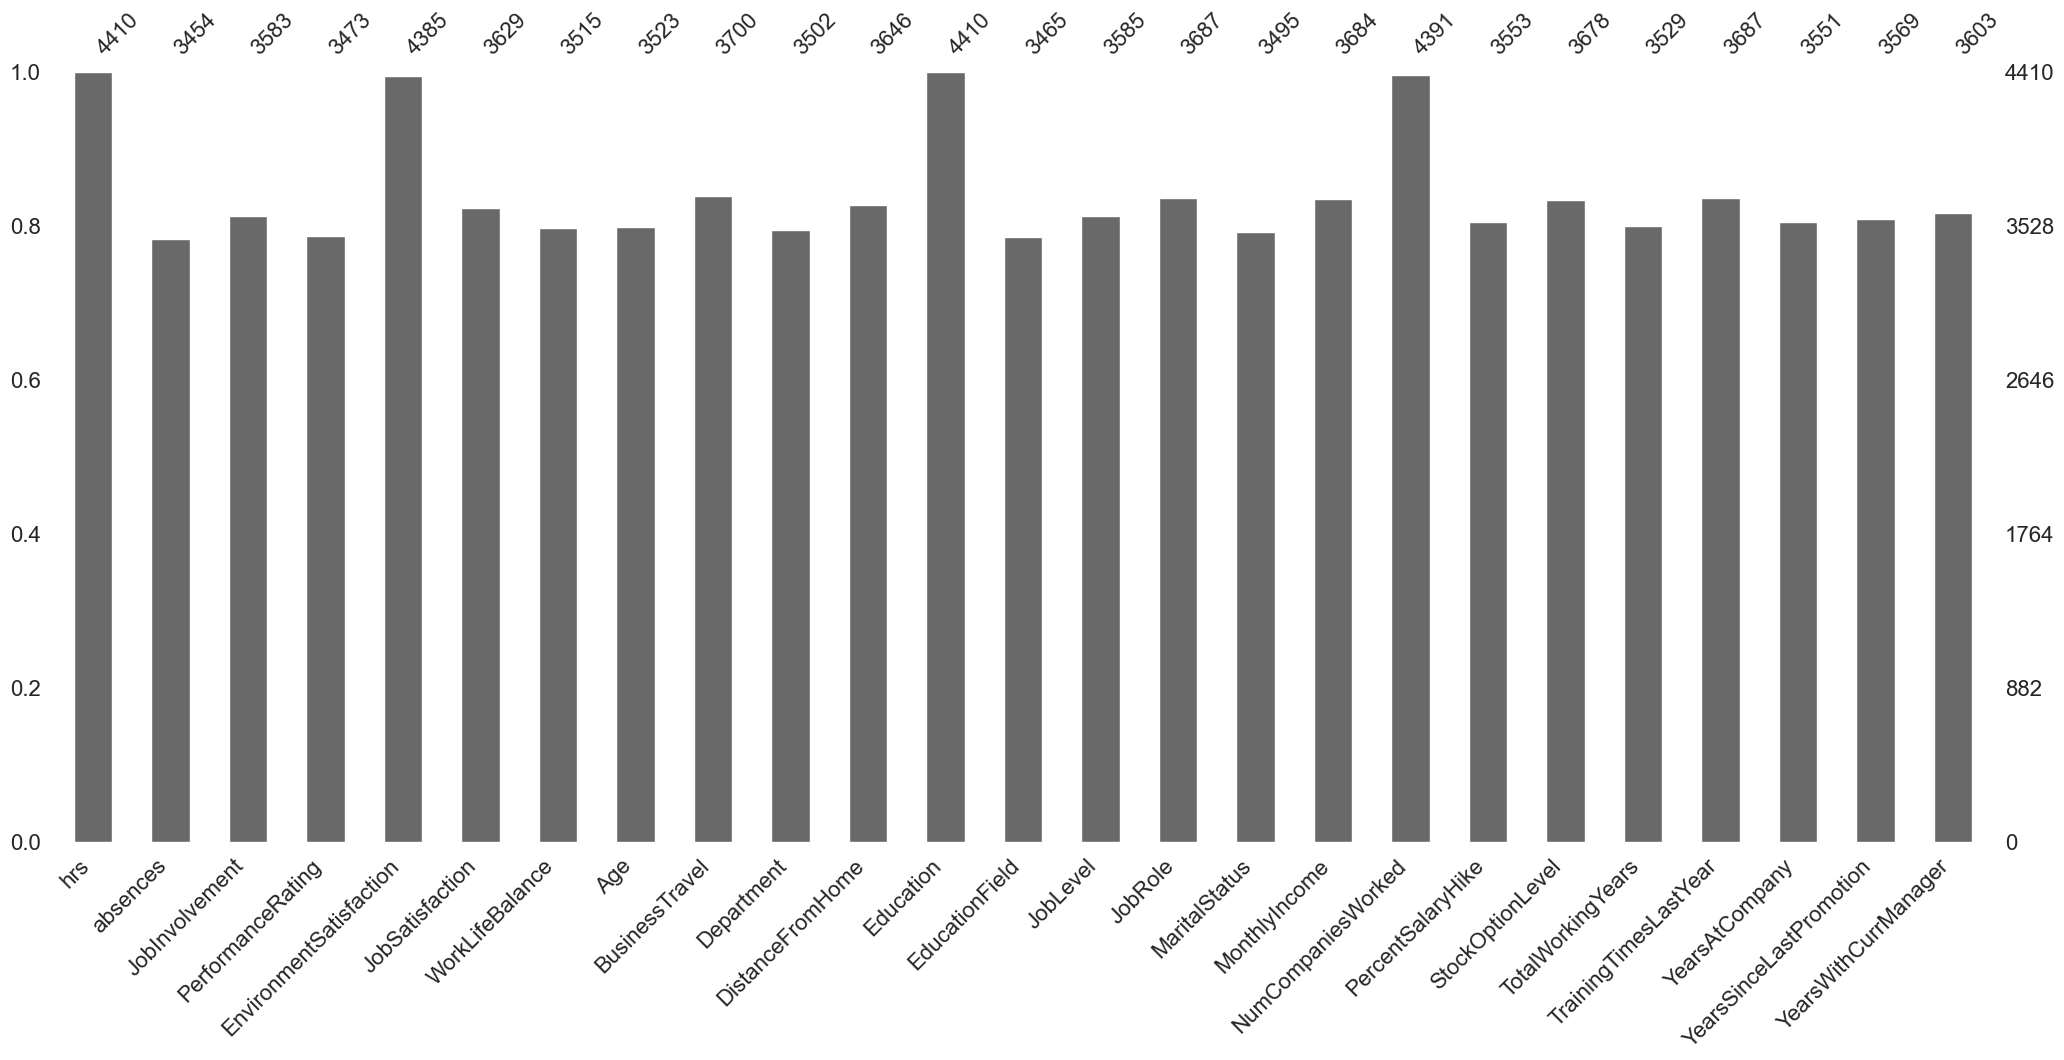

In [96]:
print('Representación de valores nulos por variable. Cuanto más cerca de 1, más precisa es al tener menos NaN:')
print('======================================')
msno.bar(X_df)
plt.show()

In [97]:
print('Este es el porcentaje de valores nulos de cada columna:')
print('======================================')
X_df.isnull().sum() / len(X_df) * 100

Este es el porcentaje de valores nulos de cada columna:


hrs                         0.000000
absences                   21.678005
JobInvolvement             18.752834
PerformanceRating          21.247166
EnvironmentSatisfaction     0.566893
JobSatisfaction            17.709751
WorkLifeBalance            20.294785
Age                        20.113379
BusinessTravel             16.099773
Department                 20.589569
DistanceFromHome           17.324263
Education                   0.000000
EducationField             21.428571
JobLevel                   18.707483
JobRole                    16.394558
MaritalStatus              20.748299
MonthlyIncome              16.462585
NumCompaniesWorked          0.430839
PercentSalaryHike          19.433107
StockOptionLevel           16.598639
TotalWorkingYears          19.977324
TrainingTimesLastYear      16.394558
YearsAtCompany             19.478458
YearsSinceLastPromotion    19.070295
YearsWithCurrManager       18.299320
dtype: float64

Por simpleza en cuanto a la realización de los modelos se ha decidido no eliminar ninguna variable con motivo de sus valores nulos. Se puede observar que no hay ninguna que presente un porcentaje desorbitado.

### Selección de conjunto train/test

Como ya hemos visto, nuestro modelo está desbalanceado, y eso hace que debamos prestar atención a la hora de dividir el conjunto de datos entre *train* y *test*. Vamos a usar **stratify** (estratificación).

***Stratify*** es una técncica que divide el conjunto de datos en subconjuntos de *train* y *test* usando una proporción parecida de clases/valores para la variable objetivo. Esto nos ayudará a aumentar la precisión del modelo.

Tras haber valorado 0.2 y 0.3, nos quedamos con la primera ya que aporta mejores resultados.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, stratify=y_df, test_size=0.2)

### Preprocesado

#### Codificación de la salida

En este apartado se utiliza la clase **LabelEncoder** de la librería scikit-learn para transformar las etiquetas categóricas de la variable objetivo y de texto a valores numéricos. 

Primero, se instancia la clase LabelEncoder y se ajusta a los valores únicos de la variable objetivo y mediante el método fit. A continuación, se transforman los conjuntos de datos de prueba y entrenamiento utilizando el método *transform*. La transformación asigna a cada valor de la variable objetivo un valor numérico distinto, comenzando por 0 y aumentando en 1 para cada valor único de la variable objetivo. De esta manera, se puede representar cada valor de la variable objetivo con un número único, lo que facilita su uso.

In [99]:
le = preprocessing.LabelEncoder()
le.fit(y_df)

y_test = le.transform(y_test)
y_train = le.transform (y_train)

#### Tratamiento de variables no numéricas


Aquí se seleccionan las columnas numéricas y categóricas se convierten las que son *object* en ***category***.

In [100]:
num_cols = X_train.select_dtypes(exclude="object").columns
cat_cols = X_train.select_dtypes(include="object").columns
X_train[cat_cols] = X_train[cat_cols].astype('category')

También teníamos la opción de tratar directamente las columnas objeto, pero ya que estamos más familiarizados y el rendimiento es el mismo, optamos por transformar a category.

#### Transformers

En este caso, se utilizan **dos transformadores diferentes**: uno para las columnas numéricas y otro para las columnas categóricas. 
- Num_transformer utiliza imputación KNN para rellenar los valores faltantes y la escala robusta para normalizar los datos. 
- Cat_transformer utiliza imputación Simple para rellenar los valores faltantes, one-hot para convertir las variables categóricas en variables numéricas y el análisis de componentes principales (PCA) para reducir la dimensionalidad de los datos.

Finalmente, ColumnTransformer combina los dos en un solo objeto ***preprocessor*** que se emplea para preprocesar los datos antes de entrenar el modelo. 


In [101]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLe...
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object'))])

---
## Modelos de Machine Learning

En nuestro análisis, hemos considerado múltiples métricas de evaluación para comprender mejor el rendimiento de nuestro modelo de clasificación en diferentes aspectos. En primer lugar, el **accuracy** es una métrica comúnmente utilizada para medir la proporción de datos clasificados correctamente en relación al total de datos. Sin embargo, esta métrica puede ser engañosa en conjuntos de datos desequilibrados, ya que el modelo podría tener un alto accuracy al clasificar correctamente la clase mayoritaria, pero ignorar completamente la clase minoritaria.

Por lo tanto, también hemos evaluado el rendimiento de nuestro modelo utilizando el **F1-score**, que es una métrica equilibrada que tiene en cuenta tanto los falsos positivos como los falsos negativos. Además, hemos utilizado el **área bajo la curva ROC (AUC-ROC)**, que es una métrica que mide la capacidad del modelo para distinguir entre las clases positivas y negativas a través de diferentes umbrales de clasificación. Esta métrica es especialmente útil en casos en los que es importante reducir tanto los falsos positivos como los falsos negativos, y donde la precisión del modelo es fundamental. Cabe destacar que para acompañar esto hemos añadido matrices de confusión.

Finalmente, hemos hecho varios **reports** que complementarán la conclusión.

***En resumen, al evaluar nuestro modelo utilizando múltiples métricas de evaluación y matrices de confusión, podemos tener una comprensión más completa del rendimiento del modelo en diferentes aspectos, y seleccionar la métrica más apropiada según el problema específico y los objetivos de la clasificación.***

>> En cuanto al budget, se ha decidido utilizar 200. Tanto por indicaciones del profesor como por ajustar los hiperparámetros mejor.

### Método Base

#### Logistic Regressor

In [102]:
# Aquí, establecemos nuestro modelo como un regresor logistico
lregr = LogisticRegression(class_weight='balanced', random_state=22)

# Hacemos el preprocesado y preparamos el modelo en un pipeline
pipe_regr_log = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', lregr)])

np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
pipe_regr_log.fit(X_train, y_train)
tiempo_fin = time.time()

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es: {balanced_accuracy_score(y_test, pipe_regr_log.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es, usando f1-score: {f1_score(y_test, pipe_regr_log.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es, usando f1-score y especificando weighted: {f1_score(y_test, pipe_regr_log.predict(X_test), average='weighted')}\n")

t_log = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_log , 'segundos')

La accuracy del modelo LogisticRegressor es: 0.693290826037305

La accuracy del modelo LogisticRegressor es, usando f1-score: 0.4260089686098654

La accuracy del modelo LogisticRegressor es, usando f1-score y especificando weighted: 0.744626241341024

El tiempo de entrenamiento del modelo es 1.4097099304199219 segundos


##### Logistic Regressor Ajustado

In [103]:
# Aquí, establecemos nuestro modelo como un regresor logistico
lregr = LogisticRegression(class_weight='balanced', random_state = 22)

# Hacemos el preprocesado y preparamos el modelo en un pipeline
pipe_regr_log = Pipeline(steps=[('scaler', preprocessor),
                                ('classifier', lregr)])

lregr_dist = {'classifier__penalty': ['l2'],
               'classifier__C': [0.05],
               'classifier__solver': ['newton-cholesky', 'newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}

param_dist = {**lregr_dist}

regr_log_h = GridSearchCV (estimator  = pipe_regr_log,
                    param_grid = param_dist,
                    scoring='accuracy',
                    cv=5,
                    refit=True,
                    n_jobs=multiprocessing.cpu_count() -1,
                    verbose=3,
                    return_train_score=True)

np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
regr_log_h.fit(X_train, y_train)
tiempo_fin = time.time()

# Mejores parametros encontrados
print('===========================================================')
print(f"Los mejores hiperparametros del modelo ajustados por LogisticRegressor son: {regr_log_h.best_params_}")

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es: {balanced_accuracy_score(y_test, regr_log_h.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es, usando f1-score: {f1_score(y_test, regr_log_h.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es, usando f1-score y especificando weighted: {f1_score(y_test, regr_log_h.predict(X_test), average='weighted')}\n")

t_logh = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_logh, 'segundos')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Los mejores hiperparametros del modelo ajustados por LogisticRegressor son: {'classifier__C': 0.05, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}
La accuracy del modelo LogisticRegressor es: 0.6946421773886562

La accuracy del modelo LogisticRegressor es, usando f1-score: 0.42792792792792794

La accuracy del modelo LogisticRegressor es, usando f1-score y especificando weighted: 0.7464533178818893

El tiempo de entrenamiento del modelo es 23.14206075668335 segundos


### Boosting

#### HistGradientBoosting

In [104]:
# Aquí, establecemos nuestro modelo como HistGradientBoostingRegressor
regr_gb = HistGradientBoostingClassifier(random_state = 22)

# Hacemos el preprocesado y preparamos el modelo en un pipeline
pipe_regr_gb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', regr_gb)])

np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
pipe_regr_gb.fit(X_train, y_train)
tiempo_fin = time.time()

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es: {balanced_accuracy_score(y_test, pipe_regr_gb.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es, usando f1-score: {f1_score(y_test, pipe_regr_gb.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es, usando f1-score y especificando weighted: {f1_score(y_test, pipe_regr_gb.predict(X_test), average='weighted')}\n")

t_gb = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_gb , 'segundos')

La accuracy del modelo HistGradientBoosting es: 0.8171869052150742

La accuracy del modelo HistGradientBoosting es, usando f1-score: 0.7540983606557378

La accuracy del modelo HistGradientBoosting es, usando f1-score y especificando weighted: 0.9272918831035435

El tiempo de entrenamiento del modelo es 2.6015710830688477 segundos


##### HistGradientBoosting Ajustado

En el caso de HistGradientBoosting, simplemente queríamos mencionar que no hemos ajustado los hiperparámetros del *preprocessor* ya que no se mejoraba el resultado. Seguramente, tal y como se nos comentó, eso estaría pensado para un poder computacional mucho mayor.

In [105]:
# Aquí, establecemos nuestro modelo como HistGradientBoostingRegressor
regr_gb = HistGradientBoostingClassifier(random_state = 22, class_weight = "balanced")


# Hacemos el preprocesado y preparamos el modelo en un pipeline
pipe_regr_gb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', regr_gb)])


# Definimos el espacio de búsqueda
gb_dist = {'classifier__max_depth'         : list(range(5, 50)),
              'classifier__learning_rate'     : [0.35, 0.4, 0.45],
              'classifier__l2_regularization' : list(range(0,10)),
              'classifier__max_leaf_nodes': list(range(10, 40)),
              'classifier__min_samples_leaf' : list(range(1, 10))
             }

param_dist = {**gb_dist}

budget = 200


regr_gb_h = RandomizedSearchCV (estimator  = pipe_regr_gb,
                           param_distributions = param_dist,
                           scoring='accuracy',
                           cv=5,
                           refit=True,
                           n_jobs=multiprocessing.cpu_count() -1,
                           verbose=3,
                           n_iter=budget,
                           return_train_score=True)

np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
regr_gb_h.fit(X_train, y_train)
tiempo_fin = time.time()

# Mejores parametros encontrados
print('===========================================================')
print(f"Los mejores hiperparametros del modelo ajustados por HistGradientBoosting son: {regr_gb_h.best_params_}")

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es: {balanced_accuracy_score(y_test, regr_gb_h.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es, usando f1-score: {f1_score(y_test, regr_gb_h.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es, usando f1-score y especificando weighted: {f1_score(y_test, regr_gb_h.predict(X_test), average='weighted')}\n")

t_gbh = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_gbh, 'segundos')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Los mejores hiperparametros del modelo ajustados por HistGradientBoosting son: {'classifier__min_samples_leaf': 4, 'classifier__max_leaf_nodes': 37, 'classifier__max_depth': 25, 'classifier__learning_rate': 0.35, 'classifier__l2_regularization': 0}
La accuracy del modelo HistGradientBoosting es: 0.8854396650171298

La accuracy del modelo HistGradientBoosting es, usando f1-score: 0.8505747126436782

La accuracy del modelo HistGradientBoosting es, usando f1-score y especificando weighted: 0.9541723496474096

El tiempo de entrenamiento del modelo es 647.6298024654388 segundos


#### XGBoost

In [106]:
# Aquí, establecemos nuestro modelo como HistGradientBoostingRegressor
regr_xg = XGBClassifier(random_state = 22)

# Hacemos el preprocesado y preparamos el modelo en un pipeline
pipe_regr_xg = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', regr_xg)])

np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
pipe_regr_xg.fit(X_train, y_train)
tiempo_fin = time.time()

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo XGBoost es: {balanced_accuracy_score(y_test, pipe_regr_xg.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando f1-score: {f1_score(y_test, pipe_regr_xg.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando f1-score y especificando weighted: {f1_score(y_test, pipe_regr_xg.predict(X_test), average='weighted')}\n")

t_xg = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_xg , 'segundos')

La accuracy del modelo XGBoost es: 0.7925390178911306

La accuracy del modelo XGBoost es, usando f1-score: 0.7172995780590717

La accuracy del modelo XGBoost es, usando f1-score y especificando weighted: 0.9176730689678462

El tiempo de entrenamiento del modelo es 1.8829624652862549 segundos


##### XGBoost Ajustado

Además, para que el modelo de XGBoost trate el desbalanceo de las clases, se puede setear el parámetro scale_pos_weight con la razón de las frecuencias de las clases. Sabemos que había dos opciones para abordar el desequilibrio:

- *class_weight='balanced'* se utiliza para asignar pesos inversamente proporcionales a las frecuencias de clase. Es decir, asigna un mayor peso a las clases minoritarias y un menor peso a las clases mayoritarias.

- *scale_pos_weight* es específica de XGBoost y se utiliza para ajustar el peso de las instancias de la clase positiva en el cálculo del gradiente durante el entrenamiento. Esta opción se calcula como sum(negative instances) / sum(positive instances).

Como class_weight='balanced' es más adecuado para conjuntos de datos con un pequeño desequilibrio de clases, y scale_pos_weight es más adecuado para conjuntos de datos con un gran desequilibrio de clases, hemos tomado la decisión de usar ***scale_pos_weight***.

In [107]:
class_freq = np.bincount(y_train)
scale_pos_weight = class_freq[0] / class_freq[1]

In [108]:
regr_xg = XGBClassifier(random_state = 22)

num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 20))}

xgboost_dist = {'classifier__n_estimators': list(range(50, 500)),
                'classifier__max_depth': list(range(2, 20)),
                'classifier__learning_rate': [0.0965, 0.0975, 0.0985],
                'classifier__scale_pos_weight' : [scale_pos_weight]}


param_dist = {**num_transformer_dist, **cat_transformer_dist, **xgboost_dist}

budget = 200 

 # Hacemos el escalado y preparamos el modelo en un pipeline
pipe_regr_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', regr_xg)])

xgboost_search_h = RandomizedSearchCV(estimator=pipe_regr_xgb,
                                      param_distributions=param_dist,
                                      scoring='accuracy',
                                      refit=True,
                                      cv=5,
                                      n_jobs=multiprocessing.cpu_count() -1,
                                      verbose=3,
                                      n_iter=budget)
 
                                     
np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
xgboost_search_h.fit(X_train, y_train)
tiempo_fin = time.time()

# Mejores parametros encontrados
print('===========================================================')
print(f"Los mejores hiperparametros del modelo ajustados por XGBoost son: {xgboost_search_h.best_params_}")

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando balanced_accuracy: {balanced_accuracy_score(y_test, xgboost_search_h.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando f1-score: {f1_score(y_test, xgboost_search_h.predict(X_test))}\n")
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando f1-score y especificando weighted: {f1_score(y_test, xgboost_search_h.predict(X_test), average='weighted')}\n")

t_xgh = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_xgh, 'segundos')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Los mejores hiperparametros del modelo ajustados por XGBoost son: {'preprocessor__num__imputer__n_neighbors': 7, 'preprocessor__num__imputer__add_indicator': False, 'preprocessor__cat__pca__n_components': 17, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__cat__imputer__add_indicator': False, 'classifier__scale_pos_weight': 5.200351493848857, 'classifier__n_estimators': 496, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.0975}
La accuracy del modelo XGBoost es, usando balanced_accuracy: 0.8904548915112296

La accuracy del modelo XGBoost es, usando f1-score: 0.849624060150376

La accuracy del modelo XGBoost es, usando f1-score y especificando weighted: 0.9533865498510087

El tiempo de entrenamiento del modelo es 713.4738163948059 segundos


---
## Evaluación del modelo

### Reports

In [109]:
print('===========================================================')
modelo_final_log_h = regr_log_h.best_estimator_
y_test_pred_log_h = modelo_final_log_h.predict(X_test)
resultado_log_h = metrics.classification_report(y_test, y_test_pred_log_h)
print("Logistic Regressor Report:",)
print (resultado_log_h)


Logistic Regressor Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       740
           1       0.31      0.67      0.43       142

    accuracy                           0.71       882
   macro avg       0.62      0.69      0.62       882
weighted avg       0.82      0.71      0.75       882



In [110]:
print('===========================================================')
modelo_final_gb_h = regr_gb_h.best_estimator_
y_test_pred_gb_h = modelo_final_gb_h.predict(X_test)
resultado_gb_h = metrics.classification_report(y_test, y_test_pred_gb_h)
print("HistGradientBoosting Report:")
print (resultado_gb_h)

HistGradientBoosting Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       740
           1       0.93      0.78      0.85       142

    accuracy                           0.96       882
   macro avg       0.95      0.89      0.91       882
weighted avg       0.96      0.96      0.95       882



In [111]:
print('===========================================================')
modelo_final_xgb_h = xgboost_search_h.best_estimator_
y_test_pred_xgb_h = modelo_final_xgb_h.predict(X_test)
resultado_xgb_h = metrics.classification_report(y_test, y_test_pred_xgb_h)
print("XGBoost Report:")
print (resultado_xgb_h)

XGBoost Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       740
           1       0.91      0.80      0.85       142

    accuracy                           0.95       882
   macro avg       0.94      0.89      0.91       882
weighted avg       0.95      0.95      0.95       882



### Obtención de Matrices de Confusión

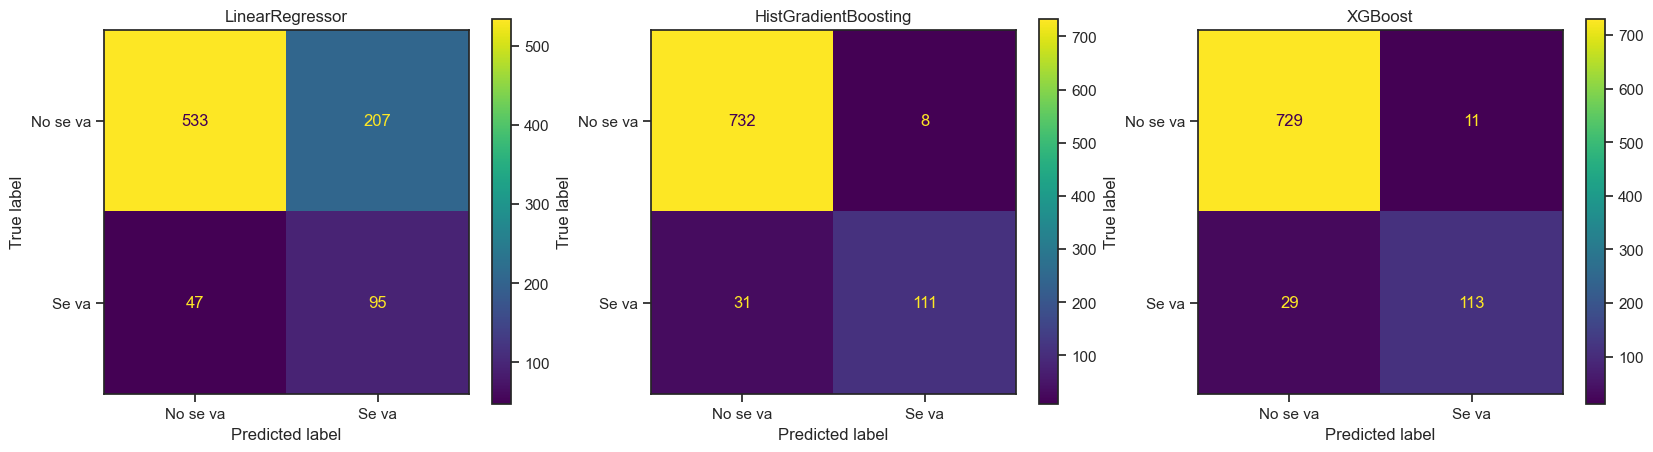

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Matriz de confusión de Logistic Regression
cmLR = confusion_matrix(y_test, y_test_pred_log_h, labels=regr_log_h.classes_)
dispLR= ConfusionMatrixDisplay(confusion_matrix=cmLR, display_labels=['No se va', 'Se va'])
dispLR.plot(ax=axs[0])
axs[0].set_title(f'LinearRegressor')

# Matriz de confusión de HistGradientBoost
cmGB= confusion_matrix(y_test, y_test_pred_gb_h, labels=regr_gb_h.classes_)
dispGB= ConfusionMatrixDisplay(confusion_matrix=cmGB, display_labels=['No se va', 'Se va'])
dispGB.plot(ax=axs[1])
axs[1].set_title(f'HistGradientBoosting')

# Matriz de confusión de XGBoost
cmXGB = confusion_matrix(y_test, y_test_pred_xgb_h, labels=xgboost_search_h.classes_)
dispXGB= ConfusionMatrixDisplay(confusion_matrix=cmXGB, display_labels=['No se va', 'Se va'])
dispXGB.plot(ax=axs[2])
axs[2].set_title(f'XGBoost')

plt.show()



Las matrices de confusión son una herramienta útil para evaluar el rendimiento de un modelo de clasificación binaria. Se utilizan para describir el rendimiento de un modelo de clasificación en términos de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

En general, un modelo de clasificación ideal tendría una matriz de confusión con ***valores altos en la diagonal principal*** (verdaderos positivos y verdaderos negativos) y **valores bajos en la diagonal secundaria** (falsos positivos y falsos negativos).

En este caso, el modelo Logistic Regression tiene una matriz de confusión con muchos menos peso en la diagonal principal; en torno a 200 verdaderos positivos menos. El modelo HistGradientBoosting y el modelo XGBoost tienen una diagonal de acierto en su matriz de confusión muchísimo mayor que Logistic Regression, por lo que podemos considerarlos mejores.

En resumen, en base a esto, los resultados obtenidos sugieren que HistGradientBoosting y XGBoost son las herramientas más efectivas para predecir el abandono de clientes.

### Obtención de Curvas ROC

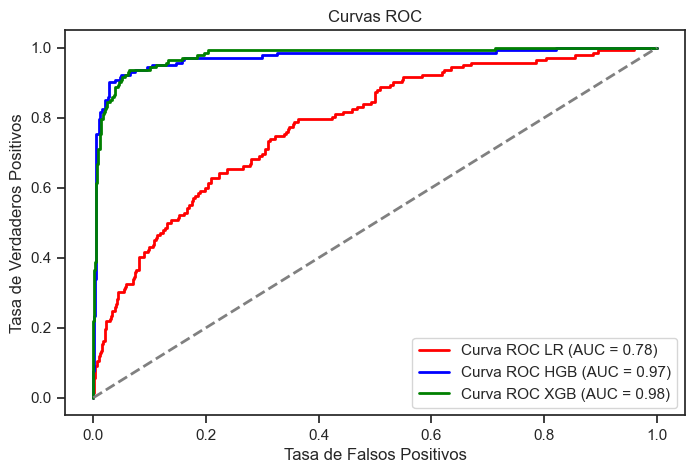

In [113]:
probsLR = regr_log_h.predict_proba(X_test)[:, 1]
probsGB = regr_gb_h.predict_proba(X_test)[:, 1]
probsXGB = xgboost_search_h.predict_proba(X_test)[:, 1]

fpr1, aucLR, _ = roc_curve(y_test, probsLR)
fpr2, aucGB, _ = roc_curve(y_test, probsGB)
fpr3, aucXGB, _ = roc_curve(y_test, probsXGB)

roc_aucLR = auc(fpr1, aucLR) 
roc_aucGB = auc(fpr2, aucGB)
roc_aucXGB = auc(fpr3, aucXGB)

plt.figure(figsize=(8, 5))
plt.plot(fpr1, aucLR, color='red', lw=2,
         label='Curva ROC LR (AUC = %0.2f)' % roc_aucLR)
plt.plot(fpr2, aucGB, color='blue', lw=2,
         label='Curva ROC HGB (AUC = %0.2f)' % roc_aucGB)
plt.plot(fpr3, aucXGB, color='green', lw=2,
         label='Curva ROC XGB (AUC = %0.2f)' % roc_aucXGB)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()

Las curvas ROC son una herramienta útil para evaluar el rendimiento de los modelos de clasificación. La curva ROC es una representación gráfica de la sensibilidad (tasa de verdaderos positivos) frente a la especificidad (tasa de falsos positivos) para diferentes umbrales. En resumidas cuentas, cuanto más cerca esté la curva ROC del borde superior izquierdo del gráfico, mejor será el rendimiento del modelo.

En este caso, los modelos HistGradientBoosting y XGBoost suelen tener una puntuación AUC de ~0.99, lo que indica un excelente rendimiento en términos de capacidad para distinguir entre las clases positivas y negativas. El modelo Logistic Regressor tiene una puntuación AUC de ~0.80, lo que indica un rendimiento moderado en términos de capacidad para distinguir entre las clases positivas y negativas.

Si tuviésemos que tomar una decisión únicamente en base a esto, podríamos elegir tanto HistGradientBoosting como XGBoost.

### Resumen

In [114]:
# Coeficientes de los distintos modelos
# ==============================================================================
d = [["LogReg", balanced_accuracy_score(y_test, regr_log_h.predict(X_test)), f1_score(y_test, regr_log_h.predict(X_test)), f1_score(y_test, regr_log_h.predict(X_test), average='weighted'), t_logh],
    ["HistGB", balanced_accuracy_score(y_test, regr_gb_h.predict(X_test)), f1_score(y_test, regr_gb_h.predict(X_test)), f1_score(y_test, regr_gb_h.predict(X_test), average='weighted'), t_gbh],
    ["XGBoost", balanced_accuracy_score(y_test, xgboost_search_h.predict(X_test)), f1_score(y_test, xgboost_search_h.predict(X_test)), f1_score(y_test, xgboost_search_h.predict(X_test), average='weighted'), t_xgh],]

df = pd.DataFrame(d, columns = ['Modelo', 'Balanced Accuracy', 'F1 Score', 'F1 Score Weighted', 'Tiempo Ejecución'])
df.style.set_properties(**{'text-align': 'center'})

,Modelo,Balanced Accuracy,F1 Score,F1 Score Weighted,Tiempo Ejecución
0,LogReg,0.694642,0.427928,0.746453,23.142061
1,HistGB,0.885440,0.850575,0.954172,647.629802
2,XGBoost,0.890455,0.849624,0.953387,713.473816


En conclusión, el modelo *XGBoost ha demostrado ser altamente efectivo* en la tarea de clasificación, logrando una precisión global del ~90.00% y una puntuación F1 de ~85.00%, lo que significa que el modelo fue capaz de predecir correctamente la mayoría de las muestras. Además, se obtuvo una puntuación F1 ponderada de ~95.00%, lo que indica un excelente rendimiento del modelo en términos de capacidad para distinguir entre las clases positivas y negativas.

El modelo *Logistic Regressor también tuvo un rendimiento bueno*, logrando una precisión global del ~69.00% y una puntuación F1 del ~43.00%, lo que significa que el modelo fue capaz de predecir correctamente una cantidad decente de muestras. Además, se obtuvo una puntuación F1 ponderada del ~75.00%, lo que indica un buen rendimiento del modelo en términos de capacidad para distinguir entre las clases positivas y negativas.

***El modelo HistGradientBoosting tuvo el mejor rendimiento en la tarea de clasificación***, logrando una precisión global del ~89.00% y una puntuación F1 de ~85.00%, lo que significa que el modelo fue capaz de predecir correctamente la mayoría de las muestras. Además, se obtuvo una puntuación F1 ponderada de ~95.00%, lo que indica un rendimiento sobervio del modelo en términos de capacidad para distinguir entre las clases positivas y negativas.

En resumen, los resultados obtenidos sugieren que tanto HistGradientBoosting como XGBoost son las herramientas más efectivas para predecir el abandono de clientes, seguidos, no muy de cerca, por Logistic Regressor. 

Si tuviésemos que tomar una decisión (este es el motivo por el que decimos que HistGradientBoosting tuvo el mejor rendimiento), y viendo las grandes similitudes que hay entre HistGradientBoosting y XGBoost, tomaríamos el camino de ***HistGradientBoosting*** ya que el tiempo de ejecución es bastante inferior.

>> NOTA: "F1 Score Weighted" se refiere a cómo se calcula el promedio de un conjunto de números, dando a cada número un peso proporcional a su importancia. En el caso del nuestro dataset, el F1 Score Weighted se refiere a la media ponderada de las métricas de cada clase. La ponderación se realiza por el número de muestras en cada clase, de manera que las clases con mayor cantidad de muestras tienen mayor peso en la métrica final.

---
# PARTE 2: aplicando el filtrado

En esta segunda parte de la práctica, nos enfocaremos en ***aplicar la técnica de selección de características con filtrado para intentar mejorar la eficacia*** de nuestros modelos de predicción de burnout en empresas. En la primera parte  ya realizamos un análisis exploratorio de los datos, tratando las columnas no relevantes en cuanto a sus instancias y las variables con valores nulos. Luego, dividimos en conjuntos de entrenamiento y prueba y ajustamos los modelos de clasificación. Ahora, en esta segunda parte, vamos a explorar cómo la selección de características con filtrado afecta a la precisión de nuestros modelos.

Para esto, comenzaremos utilizando dos técnicas diferentes: *f_classif* y *mutual_info*. Luego, compararemos los resultados de la predicción con los modelos ajustados previamente en la [PARTE 1: sin aplicar el filtrado](#práctica-2-predicción-del-abandono-burnout-de-empleados)

## Selección de características con filtrado

- **F_classif**: mide la dependencia entre las variables predictoras y la variable objetivo.

- **Mutual info:** mide la dependencia mutua entre variables, es decir, cuánta información aporta una variable sobre otra.

### F_classif

In [115]:
from sklearn.feature_selection import f_classif
threshold = 25 # the number of most relevant features

X_df_prep_f = preprocessor.fit_transform(X_df)

high_score_features_f = []
feature_scores_f = f_classif(X_df_prep_f, y_df)[0]
for score, f_name in sorted(zip(feature_scores_f, X_df.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features_f.append(f_name)
df_fc = X_df[high_score_features_f]

hrs 181.55057684137577
MaritalStatus 133.86778566259963
StockOptionLevel 110.4788814000791
Age 85.61945029322166
NumCompaniesWorked 83.85476641253298
EnvironmentSatisfaction 46.14390153062177
JobSatisfaction 38.397094950016566
TrainingTimesLastYear 29.883848653001333
WorkLifeBalance 21.7594218789329
YearsSinceLastPromotion 14.046962300336604
MonthlyIncome 11.618019199005436
EducationField 8.082457847209502
absences 6.5947883455725345
PercentSalaryHike 6.241248299233889
TotalWorkingYears 4.719151457945068
JobLevel 4.124633461162247
Education 3.0720627780597094
YearsAtCompany 2.167914675783859
JobInvolvement 1.2537303756801148
PerformanceRating 1.2427344397309117
BusinessTravel 1.2330028736729808
Department 1.0067851900784455
YearsWithCurrManager 0.9736727049799673
DistanceFromHome 0.31087315843109503
JobRole 0.027646622234442197


### Mutual info

In [116]:
from sklearn.feature_selection import mutual_info_classif
threshold = 25  # the number of most relevant features

X_df_prep_mut= preprocessor.fit_transform(X_df)

high_score_features_mut = []
feature_scores_mut = mutual_info_classif(X_df_prep_mut, y_df, random_state=22)
for score, f_name in sorted(zip(feature_scores_mut, X_df.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features_mut.append(f_name)
df_mic = X_df[high_score_features_mut]

Education 0.10170769347326725
YearsWithCurrManager 0.05338080614584717
TotalWorkingYears 0.045558442389117326
TrainingTimesLastYear 0.040988858281808316
YearsSinceLastPromotion 0.03997750851991744
hrs 0.035002502621188425
YearsAtCompany 0.03413708881875244
StockOptionLevel 0.027302823379709018
MaritalStatus 0.024472206982266487
NumCompaniesWorked 0.023711258900553256
Age 0.022135267223686306
PercentSalaryHike 0.011871309440974587
JobRole 0.007217515892713244
absences 0.007024981398746188
EducationField 0.006936904179850822
EnvironmentSatisfaction 0.0064462619859675385
BusinessTravel 0.0033500890646482873
JobInvolvement 0.002974549300590823
MonthlyIncome 0.0028328519579503553
JobLevel 0.0022781219851755186
JobSatisfaction 0.0005740265016702661
WorkLifeBalance 0.0
PerformanceRating 0.0
DistanceFromHome 0.0
Department 0.0


### Combinación de F_classif y Mutual info

Si tenemos en cuenta ambos casos, la variable más importante es "hrs", que se encuentra la séptima en Mutual Info y la primera en F_classif.

En la lista de Mutual Info, la primera es "Education", y le sigue "YearsWithCurrManager" y "TotalWorkingYears", mientras que en la lista de F_classif, "MaritalStatus" y "StockOptionLevel" son las siguientes después de "hrs".

En cuanto a las diferencias más importantes, "YearsSinceLastPromotion" y "TrainingTimesLastYear" tienen una importancia alta en Mutual Info, pero no en F_classif, mientras que "EnvironmentSatisfaction" y "JobSatisfaction" tienen una importancia alta en F_classif, pero no en Mutual Info.

Hay algunas variables tienen una importancia muy baja en ambas listas, como "WorkLifeBalance", "PerformanceRating" y "Department"; estas son las que podríamos tomar para eliminar del subconjunto de variables.

In [117]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar feature_scores_mut y feature_scores_f por separado
scaler = MinMaxScaler()
feature_scores_mut_norm = scaler.fit_transform(feature_scores_mut.reshape(-1,1)).flatten()
feature_scores_f_norm = scaler.fit_transform(feature_scores_f.reshape(-1,1)).flatten()

# Calcular puntuación ponderada
weighted_scores = (feature_scores_f_norm + feature_scores_mut_norm) / 2

# Combinar en un DataFrame
df_combined = pd.DataFrame({'mutual_info': feature_scores_mut_norm, 'f_classif': feature_scores_f_norm, 'weighted_score': weighted_scores}, index=X_df.columns)

# Ordenar por puntuación ponderada
df_combined_sorted = df_combined.sort_values('weighted_score', ascending=False)

# Imprimir tabla combinada
print(df_combined_sorted)

                         mutual_info  f_classif  weighted_score
hrs                         0.344148   1.000000        0.672074
Education                   1.000000   0.016772        0.508386
MaritalStatus               0.240613   0.737318        0.488966
StockOptionLevel            0.268444   0.608470        0.438457
NumCompaniesWorked          0.233131   0.461799        0.347465
Age                         0.217636   0.471521        0.344578
TrainingTimesLastYear       0.403006   0.164476        0.283741
YearsWithCurrManager        0.524845   0.005212        0.265028
TotalWorkingYears           0.447935   0.025845        0.236890
YearsSinceLastPromotion     0.393063   0.077232        0.235147
YearsAtCompany              0.335639   0.011791        0.173715
EnvironmentSatisfaction     0.063380   0.254052        0.158716
JobSatisfaction             0.005644   0.211375        0.108510
PercentSalaryHike           0.116720   0.034230        0.075475
WorkLifeBalance             0.000000   0

En este apartado de Selección de características con filtrado, hemos aplicado dos métodos diferentes para evaluar la importancia de las características en nuestro conjunto de datos: *f_classif* y *mutual info*. Primero, hemos aplicado el filtrado de características f_classif y ordenado las características en base a puntaje más alto. Después, hemos realizado el mismo proceso con el filtrado de características mutual info. Ambos métodos nos han proporcionado diferentes conjuntos de características relevantes, lo que indica que cada método se enfoca en diferentes aspectos de los datos.

Luego, hemos combinado ambos puntajes utilizando la media aritmética ponderada de los puntajes normalizados de ambas técnicas. Al normalizar los puntajes, hemos asegurado que cada técnica tenga la misma influencia en la combinación final. Finalmente, hemos ordenado las características por su puntaje ponderado y seleccionado las características con los puntajes más altos.

La tabla resultante muestra que las características "hrs", "Education" y "MaritalStatus" tienen los puntajes más altos y son las características más relevantes para predecir el abandono laboral. Estos resultados nos proporcionan una base sólida para continuar con el modelado y la predicción. En resumen, la combinación de métodos de filtrado de características y la normalización de los puntajes nos permitirían seleccionar las características más relevantes y significativas para nuestro modelo hipotético.

Ahora sí, vamos a proceder a ***eliminar las variables menos importantes*** de cara a realizar la comparación.


In [118]:
X_df.drop(['DistanceFromHome', 'Department', 'PerformanceRating'], axis=1, inplace=True)
print('La forma de la tabla original, disp_df, es de:')
print('===============================')
print(str(len(disp_df.index)) + ' filas y ' + str(len(disp_df.columns)) + ' columnas')
print()
print('La forma de la tabla modificada, X_df (también sin Attrition), es de:')
print('===============================')
print(str(len(X_df.index)) + ' filas y ' + str(len(X_df.columns)) + ' columnas')
print()

La forma de la tabla original, disp_df, es de:
4410 filas y 31 columnas

La forma de la tabla modificada, X_df (también sin Attrition), es de:
4410 filas y 22 columnas



## Selección de conjunto train/test

In [153]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_df, y_df, stratify=y_df, test_size=0.2)

## Preprocesado

### Codificación de la salida

In [154]:
le = preprocessing.LabelEncoder()
le.fit(y_df)

y_test2 = le.transform(y_test2)
y_train2 = le.transform (y_train2)

### Tratamiento de variables no numéricas


In [155]:
num_cols2 = X_train2.select_dtypes(exclude="object").columns
cat_cols2 = X_train2.select_dtypes(include="object").columns
X_train2[cat_cols2] = X_train2[cat_cols2].astype('category')

### Transformers

In [156]:
cat_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

num_transformer2 = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', num_transformer2, num_cols2),
        ('cat', cat_transformer2, cat_cols2)
    ])

preprocessor2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['hrs', 'absences', 'JobInvolvement', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'Age', 'Education', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimes...ear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus'], dtype='object'))])

## Modelos de Machine Learning

### Método Base

#### Logistic Regressor Ajustado

In [157]:
# Aquí, establecemos nuestro modelo como un regresor logistico
lregr = LogisticRegression(class_weight='balanced', random_state = 22)

# Hacemos el preprocesado y preparamos el modelo en un pipeline
pipe_regr_log = Pipeline(steps=[('scaler', preprocessor2),
                                ('classifier', lregr)])

lregr_dist = {'classifier__penalty': ['l2'],
               'classifier__C': [0.2],
               'classifier__solver': ['newton-cholesky', 'newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}

param_dist = {**lregr_dist}

regr_log_h2 = GridSearchCV (estimator  = pipe_regr_log,
                    param_grid = param_dist,
                    scoring='accuracy',
                    cv=5,
                    refit=True,
                    n_jobs=multiprocessing.cpu_count() -1,
                    verbose=3,
                    return_train_score=True)

np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
regr_log_h2.fit(X_train2, y_train2)
tiempo_fin = time.time()

# Mejores parametros encontrados
print('===========================================================')
print(f"Los mejores hiperparametros del modelo ajustados por LogisticRegressor son: {regr_log_h2.best_params_}")

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es: {balanced_accuracy_score(y_test2, regr_log_h2.predict(X_test2))}\n")
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es, usando f1-score: {f1_score(y_test2, regr_log_h2.predict(X_test2))}\n")
print('===========================================================')
print(f"La accuracy del modelo LogisticRegressor es, usando f1-score y especificando weighted: {f1_score(y_test2, regr_log_h2.predict(X_test2), average='weighted')}\n")

t_logh2 = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_logh2, 'segundos')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Los mejores hiperparametros del modelo ajustados por LogisticRegressor son: {'classifier__C': 0.2, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}
La accuracy del modelo LogisticRegressor es: 0.7389227255424439

La accuracy del modelo LogisticRegressor es, usando f1-score: 0.47240618101545256

La accuracy del modelo LogisticRegressor es, usando f1-score y especificando weighted: 0.7621054702579418

El tiempo de entrenamiento del modelo es 21.977308988571167 segundos


### Boosting

#### HistGradientBoosting Ajustado

In [158]:
# Aquí, establecemos nuestro modelo como HistGradientBoostingRegressor
regr_gb = HistGradientBoostingClassifier(random_state = 22, class_weight = "balanced")


# Hacemos el preprocesado y preparamos el modelo en un pipeline
pipe_regr_gb = Pipeline(steps=[('preprocessor', preprocessor2),
                               ('classifier', regr_gb)])


# Definimos el espacio de búsqueda
gb_dist = {'classifier__max_depth'         : list(range(5, 50)),
              'classifier__learning_rate'     : [0.4, 0.45, 0.5],
              'classifier__l2_regularization' : list(range(0,10)),
              'classifier__max_leaf_nodes': list(range(10, 40)),
              'classifier__min_samples_leaf' : list(range(1, 10))
             }

param_dist = {**gb_dist}

budget = 200


regr_gb_h2 = RandomizedSearchCV (estimator  = pipe_regr_gb,
                           param_distributions = param_dist,
                           scoring='accuracy',
                           cv=5,
                           refit=True,
                           n_jobs=multiprocessing.cpu_count() -1,
                           verbose=3,
                           n_iter=budget,
                           return_train_score=True)

np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
regr_gb_h2.fit(X_train2, y_train2)
tiempo_fin = time.time()

# Mejores parametros encontrados
print('===========================================================')
print(f"Los mejores hiperparametros del modelo ajustados por HistGradientBoosting son: {regr_gb_h2.best_params_}")

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es: {balanced_accuracy_score(y_test2, regr_gb_h2.predict(X_test2))}\n")
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es, usando f1-score: {f1_score(y_test2, regr_gb_h2.predict(X_test2))}\n")
print('===========================================================')
print(f"La accuracy del modelo HistGradientBoosting es, usando f1-score y especificando weighted: {f1_score(y_test2, regr_gb_h2.predict(X_test2), average='weighted')}\n")

t_gbh2 = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_gbh2, 'segundos')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Los mejores hiperparametros del modelo ajustados por HistGradientBoosting son: {'classifier__min_samples_leaf': 9, 'classifier__max_leaf_nodes': 33, 'classifier__max_depth': 36, 'classifier__learning_rate': 0.4, 'classifier__l2_regularization': 0}
La accuracy del modelo HistGradientBoosting es: 0.8594404263418348

La accuracy del modelo HistGradientBoosting es, usando f1-score: 0.8124999999999999

La accuracy del modelo HistGradientBoosting es, usando f1-score y especificando weighted: 0.9431072827008788

El tiempo de entrenamiento del modelo es 629.6594023704529 segundos


#### XGBoost Ajustado

In [159]:
class_freq2 = np.bincount(y_train2)
scale_pos_weight2 = class_freq2[0] / class_freq2[1]

In [160]:
regr_xg = XGBClassifier(random_state = 22)

num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 20))}

xgboost_dist = {'classifier__n_estimators': list(range(50, 500)),
                'classifier__max_depth': list(range(2, 20)),
                'classifier__learning_rate': [0.0965, 0.0975, 0.0985],
                'classifier__scale_pos_weight' : [scale_pos_weight2]}


param_dist = {**num_transformer_dist, **cat_transformer_dist, **xgboost_dist}

budget = 200 

 # Hacemos el escalado y preparamos el modelo en un pipeline
pipe_regr_xgb = Pipeline(steps=[('preprocessor', preprocessor2),
                               ('classifier', regr_xg)])

xgboost_search_h2 = RandomizedSearchCV(estimator=pipe_regr_xgb,
                                      param_distributions=param_dist,
                                      scoring='accuracy',
                                      refit=True,
                                      cv=5,
                                      n_jobs=multiprocessing.cpu_count() -1,
                                      verbose=3,
                                      n_iter=budget)
 
                                     
np.random.seed(22) # Reproductibilidad

# Lo entrenamos
tiempo_inicio = time.time()
xgboost_search_h2.fit(X_train2, y_train2)
tiempo_fin = time.time()

# Mejores parametros encontrados
print('===========================================================')
print(f"Los mejores hiperparametros del modelo ajustados por XGBoost son: {xgboost_search_h2.best_params_}")

# Evaluamos la precisión del modelo
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando balanced_accuracy: {balanced_accuracy_score(y_test2, xgboost_search_h2.predict(X_test2))}\n")
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando f1-score: {f1_score(y_test2, xgboost_search_h2.predict(X_test2))}\n")
print('===========================================================')
print(f"La accuracy del modelo XGBoost es, usando f1-score y especificando weighted: {f1_score(y_test2, xgboost_search_h2.predict(X_test2), average='weighted')}\n")

t_xgh2 = tiempo_fin - tiempo_inicio
print('===========================================================')
print("El tiempo de entrenamiento del modelo es", t_xgh2, 'segundos')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Los mejores hiperparametros del modelo ajustados por XGBoost son: {'preprocessor__num__imputer__n_neighbors': 2, 'preprocessor__num__imputer__add_indicator': False, 'preprocessor__cat__pca__n_components': 3, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__cat__imputer__add_indicator': False, 'classifier__scale_pos_weight': 5.200351493848857, 'classifier__n_estimators': 118, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.0975}
La accuracy del modelo XGBoost es, usando balanced_accuracy: 0.8819185382565664

La accuracy del modelo XGBoost es, usando f1-score: 0.846153846153846

La accuracy del modelo XGBoost es, usando f1-score y especificando weighted: 0.9529172279932157

El tiempo de entrenamiento del modelo es 651.4205257892609 segundos


## Evaluación del modelo

### Reports

In [161]:
print('===========================================================')
modelo_final_log_h2 = regr_log_h2.best_estimator_
y_test_pred_log_h2 = modelo_final_log_h2.predict(X_test2)
resultado_log_h2 = metrics.classification_report(y_test2, y_test_pred_log_h2)
print("Logistic Regressor Report:",)
print (resultado_log_h2)


Logistic Regressor Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       740
           1       0.34      0.75      0.47       142

    accuracy                           0.73       882
   macro avg       0.64      0.74      0.65       882
weighted avg       0.84      0.73      0.76       882



In [162]:
print('===========================================================')
modelo_final_gb_h2 = regr_gb_h2.best_estimator_
y_test_pred_gb_h2 = modelo_final_gb_h2.predict(X_test2)
resultado_gb_h2 = metrics.classification_report(y_test2, y_test_pred_gb_h2)
print("HistGradientBoosting Report:")
print (resultado_gb_h2)

HistGradientBoosting Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       740
           1       0.91      0.73      0.81       142

    accuracy                           0.95       882
   macro avg       0.93      0.86      0.89       882
weighted avg       0.94      0.95      0.94       882



In [163]:
print('===========================================================')
modelo_final_xgb_h2 = xgboost_search_h2.best_estimator_
y_test_pred_xgb_h2 = modelo_final_xgb_h2.predict(X_test2)
resultado_xgb_h2 = metrics.classification_report(y_test2, y_test_pred_xgb_h2)
print("XGBoost Report:")
print (resultado_xgb_h2)

XGBoost Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       740
           1       0.93      0.77      0.85       142

    accuracy                           0.95       882
   macro avg       0.95      0.88      0.91       882
weighted avg       0.95      0.95      0.95       882



### Obtención de Matrices de Confusión

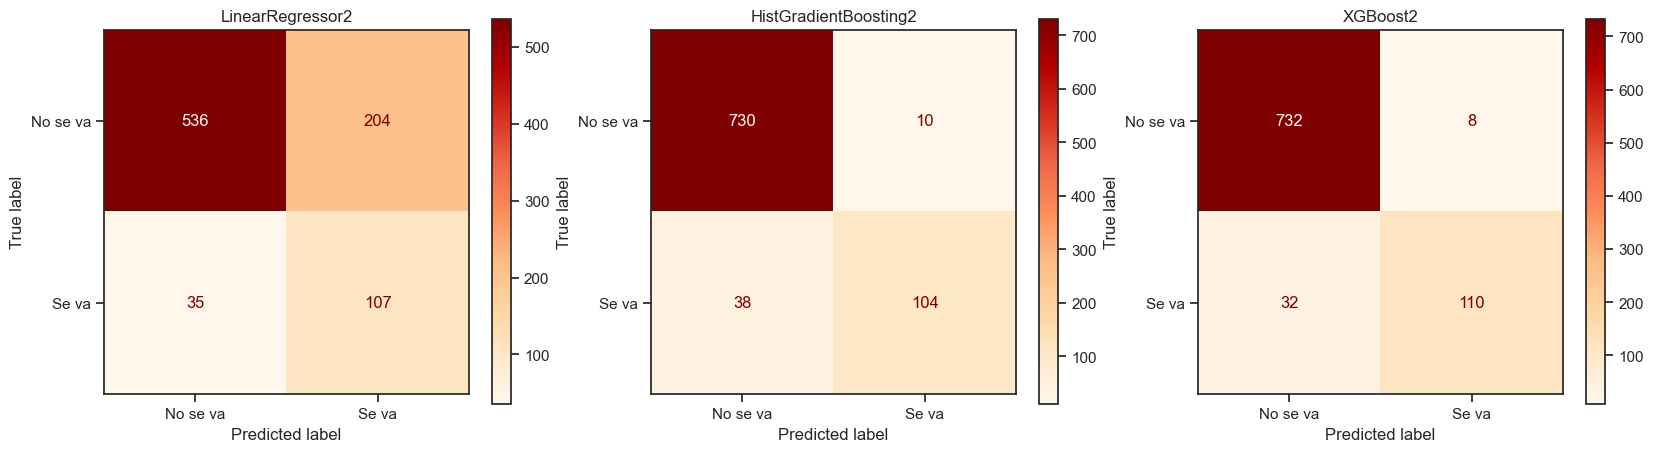

In [164]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Matriz de confusión de Logistic Regression
cmLR2 = confusion_matrix(y_test2, y_test_pred_log_h2, labels=regr_log_h2.classes_)
dispLR2= ConfusionMatrixDisplay(confusion_matrix=cmLR2, display_labels=['No se va', 'Se va'])
dispLR2.plot(ax=axs[0], cmap ='OrRd')
axs[0].set_title(f'LinearRegressor2')

# Matriz de confusión de HistGradientBoost
cmGB2 = confusion_matrix(y_test2, y_test_pred_gb_h2, labels=regr_gb_h2.classes_)
dispGB2 = ConfusionMatrixDisplay(confusion_matrix=cmGB2, display_labels=['No se va', 'Se va'])
dispGB2.plot(ax=axs[1], cmap ='OrRd')
axs[1].set_title(f'HistGradientBoosting2')

# Matriz de confusión de XGBoost
cmXGB2 = confusion_matrix(y_test2, y_test_pred_xgb_h2, labels=xgboost_search_h2.classes_)
dispXGB2 = ConfusionMatrixDisplay(confusion_matrix=cmXGB2, display_labels=['No se va', 'Se va'])
dispXGB2.plot(ax=axs[2], cmap ='OrRd')
axs[2].set_title(f'XGBoost2')

plt.show()



### Obtención de Curvas ROC

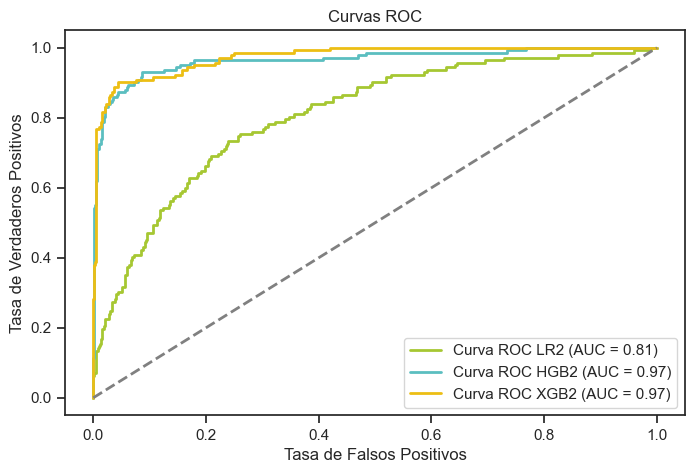

In [165]:
probsLR2 = regr_log_h2.predict_proba(X_test2)[:, 1]
probsGB2 = regr_gb_h2.predict_proba(X_test2)[:, 1]
probsXGB2 = xgboost_search_h2.predict_proba(X_test2)[:, 1]

fpr4, aucLR2, _ = roc_curve(y_test2, probsLR2)
fpr5, aucGB2, _ = roc_curve(y_test2, probsGB2)
fpr6, aucXGB2, _ = roc_curve(y_test2, probsXGB2)

roc_aucLR2 = auc(fpr4, aucLR2) 
roc_aucGB2 = auc(fpr5, aucGB2)
roc_aucXGB2 = auc(fpr6, aucXGB2)

plt.figure(figsize=(8, 5))
plt.plot(fpr4, aucLR2, color='#a6c732', lw=2,
         label='Curva ROC LR2 (AUC = %0.2f)' % roc_aucLR2)
plt.plot(fpr5, aucGB2, color='#5bbec0', lw=2,
         label='Curva ROC HGB2 (AUC = %0.2f)' % roc_aucGB2)
plt.plot(fpr6, aucXGB2, color='#ecbe14', lw=2,
         label='Curva ROC XGB2 (AUC = %0.2f)' % roc_aucXGB2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()

## Resumen

In [166]:
# Coeficientes de los distintos modelos
# ==============================================================================
d = [["LogReg2", balanced_accuracy_score(y_test2, regr_log_h2.predict(X_test2)), f1_score(y_test2, regr_log_h2.predict(X_test2)), f1_score(y_test2, regr_log_h2.predict(X_test2), average='weighted'), t_logh2],
    ["HistGB2", balanced_accuracy_score(y_test2, regr_gb_h2.predict(X_test2)), f1_score(y_test2, regr_gb_h2.predict(X_test2)), f1_score(y_test2, regr_gb_h2.predict(X_test2), average='weighted'), t_gbh2],
    ["XGBoost2", balanced_accuracy_score(y_test2, xgboost_search_h2.predict(X_test2)), f1_score(y_test2, xgboost_search_h2.predict(X_test2)), f1_score(y_test2, xgboost_search_h2.predict(X_test2), average='weighted'), t_xgh2],]

df = pd.DataFrame(d, columns = ['Modelo', 'Balanced Accuracy', 'F1 Score', 'F1 Score Weighted', 'Tiempo Ejecución'])
df.style.set_properties(**{'text-align': 'center'})

,Modelo,Balanced Accuracy,F1 Score,F1 Score Weighted,Tiempo Ejecución
0,LogReg2,0.738923,0.472406,0.762105,21.977309
1,HistGB2,0.859440,0.812500,0.943107,629.659402
2,XGBoost2,0.881919,0.846154,0.952917,651.420526


Tras aplicar selección de características con filtrado en los datos, se ha observado lo siguiente.

El modelo Logistic Regressor ha **mejorado su rendimiento** en comparación con los resultados de la primera parte, logrando una precisión global del ~74.00% y una puntuación F1 del ~47.00%, lo que significa que el modelo fue capaz de predecir correctamente una cantidad decente de muestras. Además, se obtuvo una puntuación F1 ponderada del ~76.00%, lo que indica un buen rendimiento del modelo en términos de capacidad para distinguir entre las clases positivas y negativas.

En cuanto a los modelos basados en árboles de decisión, ambos han mantenido su efectividad (han perdido ligeramente ya que tienen menos variables con las que entrenar), pero se ha notado una disminución en el tiempo de ejecución en comparación con la primera parte. El modelo HistGradientBoosting ha logrado una precisión global del ~86.00% y una puntuación F1 del ~81.00%, mientras que XGBoost ha obtenido una precisión global del ~88.00% y una puntuación F1 del ~85.00%.

En conclusión, la selección de características con filtrado ha mantenido el rendimiento de los modelos, destacando especialmente la mejora del modelo Logistic Regressor y siendo notable la disminución en tiempos de ejecución.

# PARTE 3: Comparación y selección de MODELO FINAL

## Matrices de Confusión

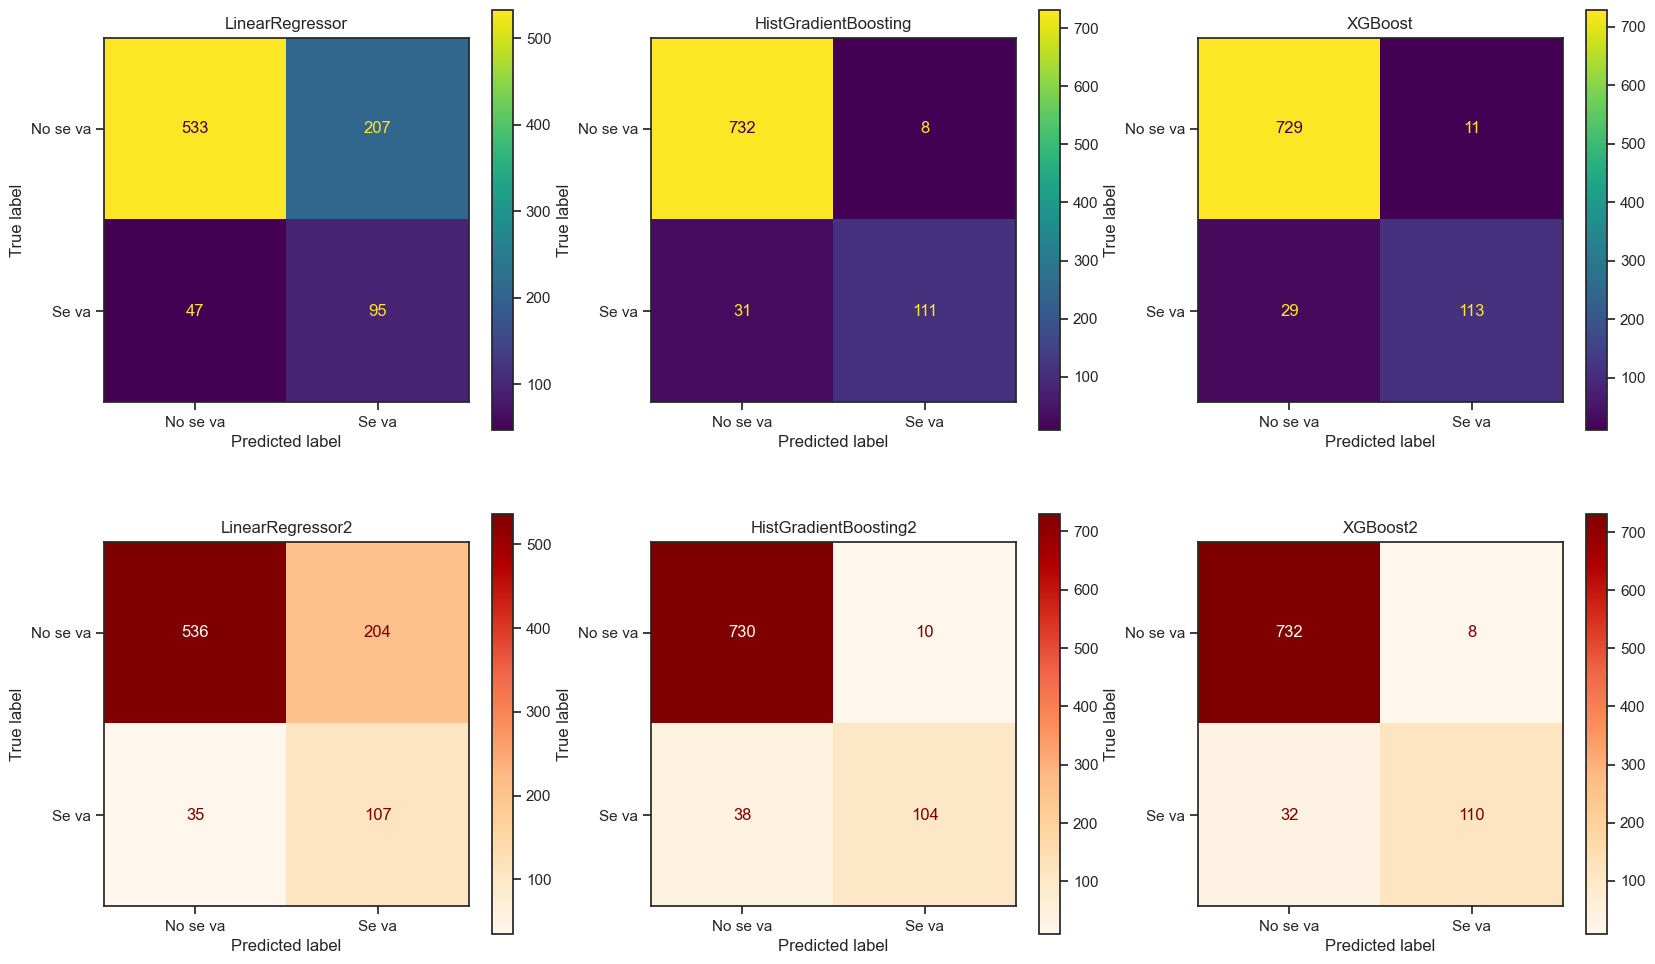

In [167]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Matriz de confusión de Logistic Regression
cmLR = confusion_matrix(y_test, y_test_pred_log_h, labels=regr_log_h.classes_)
dispLR= ConfusionMatrixDisplay(confusion_matrix=cmLR, display_labels=['No se va', 'Se va'])
dispLR.plot(ax=axs[0, 0])
axs[0, 0].set_title(f'LinearRegressor')

# Matriz de confusión de HistGradientBoost
cmGB= confusion_matrix(y_test, y_test_pred_gb_h, labels=regr_gb_h.classes_)
dispGB= ConfusionMatrixDisplay(confusion_matrix=cmGB, display_labels=['No se va', 'Se va'])
dispGB.plot(ax=axs[0, 1])
axs[0, 1].set_title(f'HistGradientBoosting')

# Matriz de confusión de XGBoost
cmXGB = confusion_matrix(y_test, y_test_pred_xgb_h, labels=xgboost_search_h.classes_)
dispXGB= ConfusionMatrixDisplay(confusion_matrix=cmXGB, display_labels=['No se va', 'Se va'])
dispXGB.plot(ax=axs[0, 2])
axs[0, 2].set_title(f'XGBoost')

# Matriz de confusión de Logistic Regression
cmLR2 = confusion_matrix(y_test2, y_test_pred_log_h2, labels=regr_log_h2.classes_)
dispLR2= ConfusionMatrixDisplay(confusion_matrix=cmLR2, display_labels=['No se va', 'Se va'])
dispLR2.plot(ax=axs[1, 0], cmap='OrRd')
axs[1, 0].set_title(f'LinearRegressor2')

# Matriz de confusión de HistGradientBoost
cmGB2 = confusion_matrix(y_test2, y_test_pred_gb_h2, labels=regr_gb_h2.classes_)
dispGB2 = ConfusionMatrixDisplay(confusion_matrix=cmGB2, display_labels=['No se va', 'Se va'])
dispGB2.plot(ax=axs[1, 1], cmap="OrRd")
axs[1, 1].set_title(f'HistGradientBoosting2')

# Matriz de confusión de XGBoost
cmXGB2 = confusion_matrix(y_test2, y_test_pred_xgb_h2, labels=xgboost_search_h2.classes_)
dispXGB2 = ConfusionMatrixDisplay(confusion_matrix=cmXGB2, display_labels=['No se va', 'Se va'])
dispXGB2.plot(ax=axs[1, 2], cmap='OrRd')
axs[1, 2].set_title(f'XGBoost2')



plt.show()

## Curvas ROC

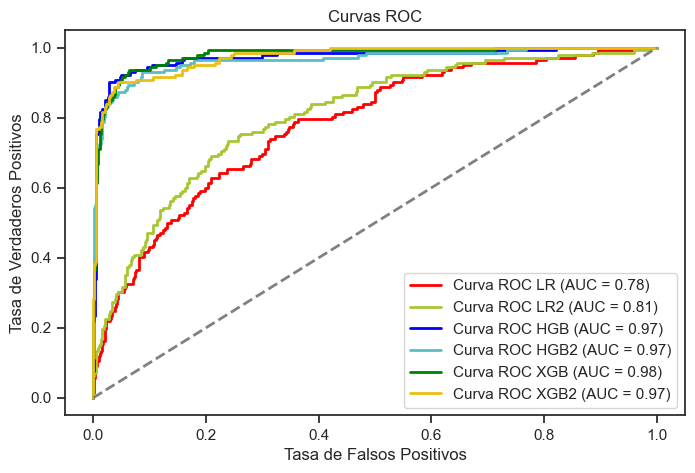

In [168]:
probsLR = regr_log_h.predict_proba(X_test)[:, 1]
probsGB = regr_gb_h.predict_proba(X_test)[:, 1]
probsXGB = xgboost_search_h.predict_proba(X_test)[:, 1]

fpr1, aucLR, _ = roc_curve(y_test, probsLR)
fpr2, aucGB, _ = roc_curve(y_test, probsGB)
fpr3, aucXGB, _ = roc_curve(y_test, probsXGB)

roc_aucLR = auc(fpr1, aucLR) 
roc_aucGB = auc(fpr2, aucGB)
roc_aucXGB = auc(fpr3, aucXGB)

probsLR2 = regr_log_h2.predict_proba(X_test2)[:, 1]
probsGB2 = regr_gb_h2.predict_proba(X_test2)[:, 1]
probsXGB2 = xgboost_search_h2.predict_proba(X_test2)[:, 1]

fpr4, aucLR2, _ = roc_curve(y_test2, probsLR2)
fpr5, aucGB2, _ = roc_curve(y_test2, probsGB2)
fpr6, aucXGB2, _ = roc_curve(y_test2, probsXGB2)

roc_aucLR2 = auc(fpr4, aucLR2) 
roc_aucGB2 = auc(fpr5, aucGB2)
roc_aucXGB2 = auc(fpr6, aucXGB2)

plt.figure(figsize=(8, 5))
plt.plot(fpr1, aucLR, color='red', lw=2,
         label='Curva ROC LR (AUC = %0.2f)' % roc_aucLR)
plt.plot(fpr4, aucLR2, color='#a6c732', lw=2,
         label='Curva ROC LR2 (AUC = %0.2f)' % roc_aucLR2)

plt.plot(fpr2, aucGB, color='blue', lw=2,
         label='Curva ROC HGB (AUC = %0.2f)' % roc_aucGB)
plt.plot(fpr5, aucGB2, color='#5bbec0', lw=2,
         label='Curva ROC HGB2 (AUC = %0.2f)' % roc_aucGB2)

plt.plot(fpr3, aucXGB, color='green', lw=2,
         label='Curva ROC XGB (AUC = %0.2f)' % roc_aucXGB)
plt.plot(fpr6, aucXGB2, color='#ecbe14', lw=2,
         label='Curva ROC XGB2 (AUC = %0.2f)' % roc_aucXGB2)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()

## Comparación Final

In [169]:
# Coeficientes de los distintos modelos
# ==============================================================================
d = [["LogReg", balanced_accuracy_score(y_test, regr_log_h.predict(X_test)), f1_score(y_test, regr_log_h.predict(X_test)), f1_score(y_test, regr_log_h.predict(X_test), average='weighted'), t_logh],
    ["LogReg2", balanced_accuracy_score(y_test2, regr_log_h2.predict(X_test2)), f1_score(y_test2, regr_log_h2.predict(X_test2)), f1_score(y_test2, regr_log_h2.predict(X_test2), average='weighted'), t_logh2],
    ["HistGB", balanced_accuracy_score(y_test, regr_gb_h.predict(X_test)), f1_score(y_test, regr_gb_h.predict(X_test)), f1_score(y_test, regr_gb_h.predict(X_test), average='weighted'), t_gbh],
    ["HistGB2", balanced_accuracy_score(y_test2, regr_gb_h2.predict(X_test2)), f1_score(y_test2, regr_gb_h2.predict(X_test2)), f1_score(y_test2, regr_gb_h2.predict(X_test2), average='weighted'), t_gbh2],
    ["XGBoost", balanced_accuracy_score(y_test, xgboost_search_h.predict(X_test)), f1_score(y_test, xgboost_search_h.predict(X_test)), f1_score(y_test, xgboost_search_h.predict(X_test), average='weighted'), t_xgh],
    ["XGBoost2", balanced_accuracy_score(y_test2, xgboost_search_h2.predict(X_test2)), f1_score(y_test2, xgboost_search_h2.predict(X_test2)), f1_score(y_test2, xgboost_search_h2.predict(X_test2), average='weighted'), t_xgh2],]

df = pd.DataFrame(d, columns = ['Modelo', 'Balanced Accuracy', 'F1 Score', 'F1 Score Weighted', 'Tiempo Ejecución'])
df.style.set_properties(**{'text-align': 'center'})

,Modelo,Balanced Accuracy,F1 Score,F1 Score Weighted,Tiempo Ejecución
0,LogReg,0.694642,0.427928,0.746453,23.142061
1,LogReg2,0.738923,0.472406,0.762105,21.977309
2,HistGB,0.885440,0.850575,0.954172,647.629802
3,HistGB2,0.859440,0.812500,0.943107,629.659402
4,XGBoost,0.890455,0.849624,0.953387,713.473816
5,XGBoost2,0.881919,0.846154,0.952917,651.420526


Durante el desarrollo de esta práctica se ha aplicado selección de características para evaluar su efecto en la tarea de clasificación de abandono de clientes. Se han utilizado seis modelos diferentes y se han obtenido métricas de rendimiento, como Balanced Accuracy, F1 Score y F1 Score ponderado, y tiempo de ejecución para cada uno de ellos. Tras comparar los resultados, se ha decidido elegir el modelo HistGradientBoosting como el más efectivo para la tarea de clasificación de abandono de clientes, ya que su rendimiento es similar al de XGBoost, pero con un tiempo de ejecución significativamente menor. Aunque con esta base de datos los tiempos de ejecución no son extremadamente altos, queremos ponernos en el lugar de una situación real de millones de datos y servidores.

En el siguiente paso, se procederá a crear y ajustar el modelo final utilizando HistGradientBoosting en el archivo [modelo_final.ipynb](modelo_final.ipynb). Cabe destacar que vamos a usar slección de características por filtrado.

*Disclaimer*:
Hemos ejecutado los modelos las suficientes veces como para obtener resultado convincentes. A veces había variaciones en los modelos, pero si miramos con perspectiva las conclusiones son las presentadas. Dicho esto, lo que más hemos notado es la **reducción en tiempos de ejecución**. 

***Estos resultados respaldan la eficacia de la selección de características por filtrado en la mejora del rendimiento del modelo y demuestran su utilidad en la construcción de modelos de aprendizaje automático precisos y eficientes***.


>> NOTA: debido a la selección de conjuntos de entrenamiento/test, los resultados pueden variar ligeramente; sin embargo, hemos argumentado y concluido en base a los resultado que más hemos obtenido.

In [174]:
modelo_final_gb_h2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['hrs', 'absences', 'JobInvolvement', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'Age', 'Education', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'T...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  Index(['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus'], dtype='object'))])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0,
                                                learning_rate=0.4, max_depth=36,
                                                max_leaf_nodes=33,
                                                min_samples_leaf=9,
                                                random_state=22))])